# Workout Classifier 🏋️‍♀️

## Introduction

This notebook walks through, step by step, how I built a deep-learning system that recognises **22 gym exercises** from short video clips.

**What you’ll find inside**

1. **Dataset download & quick tour** – pulls the [*Workout Fitness Video*](https://www.kaggle.com/datasets/hasyimabdillah/workoutfitness-video) dataset from Kaggle and inspects class balance, clip length and example frames.  
2. **Two preprocessing pipelines**  
   * **Frame-based** – extract RGB frames ➜ train an image classifier (a lightweight CNN and a fine-tuned ViT-B/16).  
   * **Pose-based** – extract **3-D body landmarks** with MediaPipe Pose, **append per-joint velocities and confidence scores** ➜ feed the sequences to custom **Multi-Stream models** (ConvLSTM & Transformer).

> **Tip:** A GPU makes training much faster. Once the dataset is in place, just run the cells in order and watch the models learn to spot each exercise.

> **Important:**  
> 1. Download the [Workout Fitness Video dataset from Kaggle](https://www.kaggle.com/datasets/hasyimabdillah/workoutfitness-video) and place it in a folder called `dataset` in the same directory as this notebook.
> 2. Init a virtual environment and use it to run this notebook.

Now let’s install the dependencies and import the required modules:


In [1]:
# Uncomment the following line if you have a GPU and want to use it
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
%pip install torch torchvision torchaudio
%pip install mediapipe
%pip install pytorch-lightning
%pip install tensorflow
%pip install keras
%pip install opencv-python
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install pandas
%pip install numpy
%pip install tqdm
%pip install pillow
%pip install transformers

print("📦 Project requirements ready!")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
📦 Project requirements ready!


In [2]:
import torch
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import random
import mediapipe as mp
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')


/opt/homebrew/Caskroom/miniforge/base/envs/vidc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Checking for GPU availability:

In [3]:
def check_device():
    """Check and set GPU -> CUDA | MPS | CPU)"""
    
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"🚀 CUDA GPU available: {torch.cuda.get_device_name(0)}")
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
        print("🍎 Apple Silicon GPU (MPS) available")
    else:
        device = torch.device('cpu')
        print("💻 Using CPU (consider using GPU for faster training)")
    
    print(f"PyTorch Version: {torch.__version__}")
    print(f"Device set to: {device}")
    
    return device

# Set global device
device = check_device()

🍎 Apple Silicon GPU (MPS) available
PyTorch Version: 2.7.0
Device set to: mps


## Visualize the dataset

There is no better way to understand the dataset than by visualizing it.

Average video duration: 7.86 seconds
Number of videos: 652


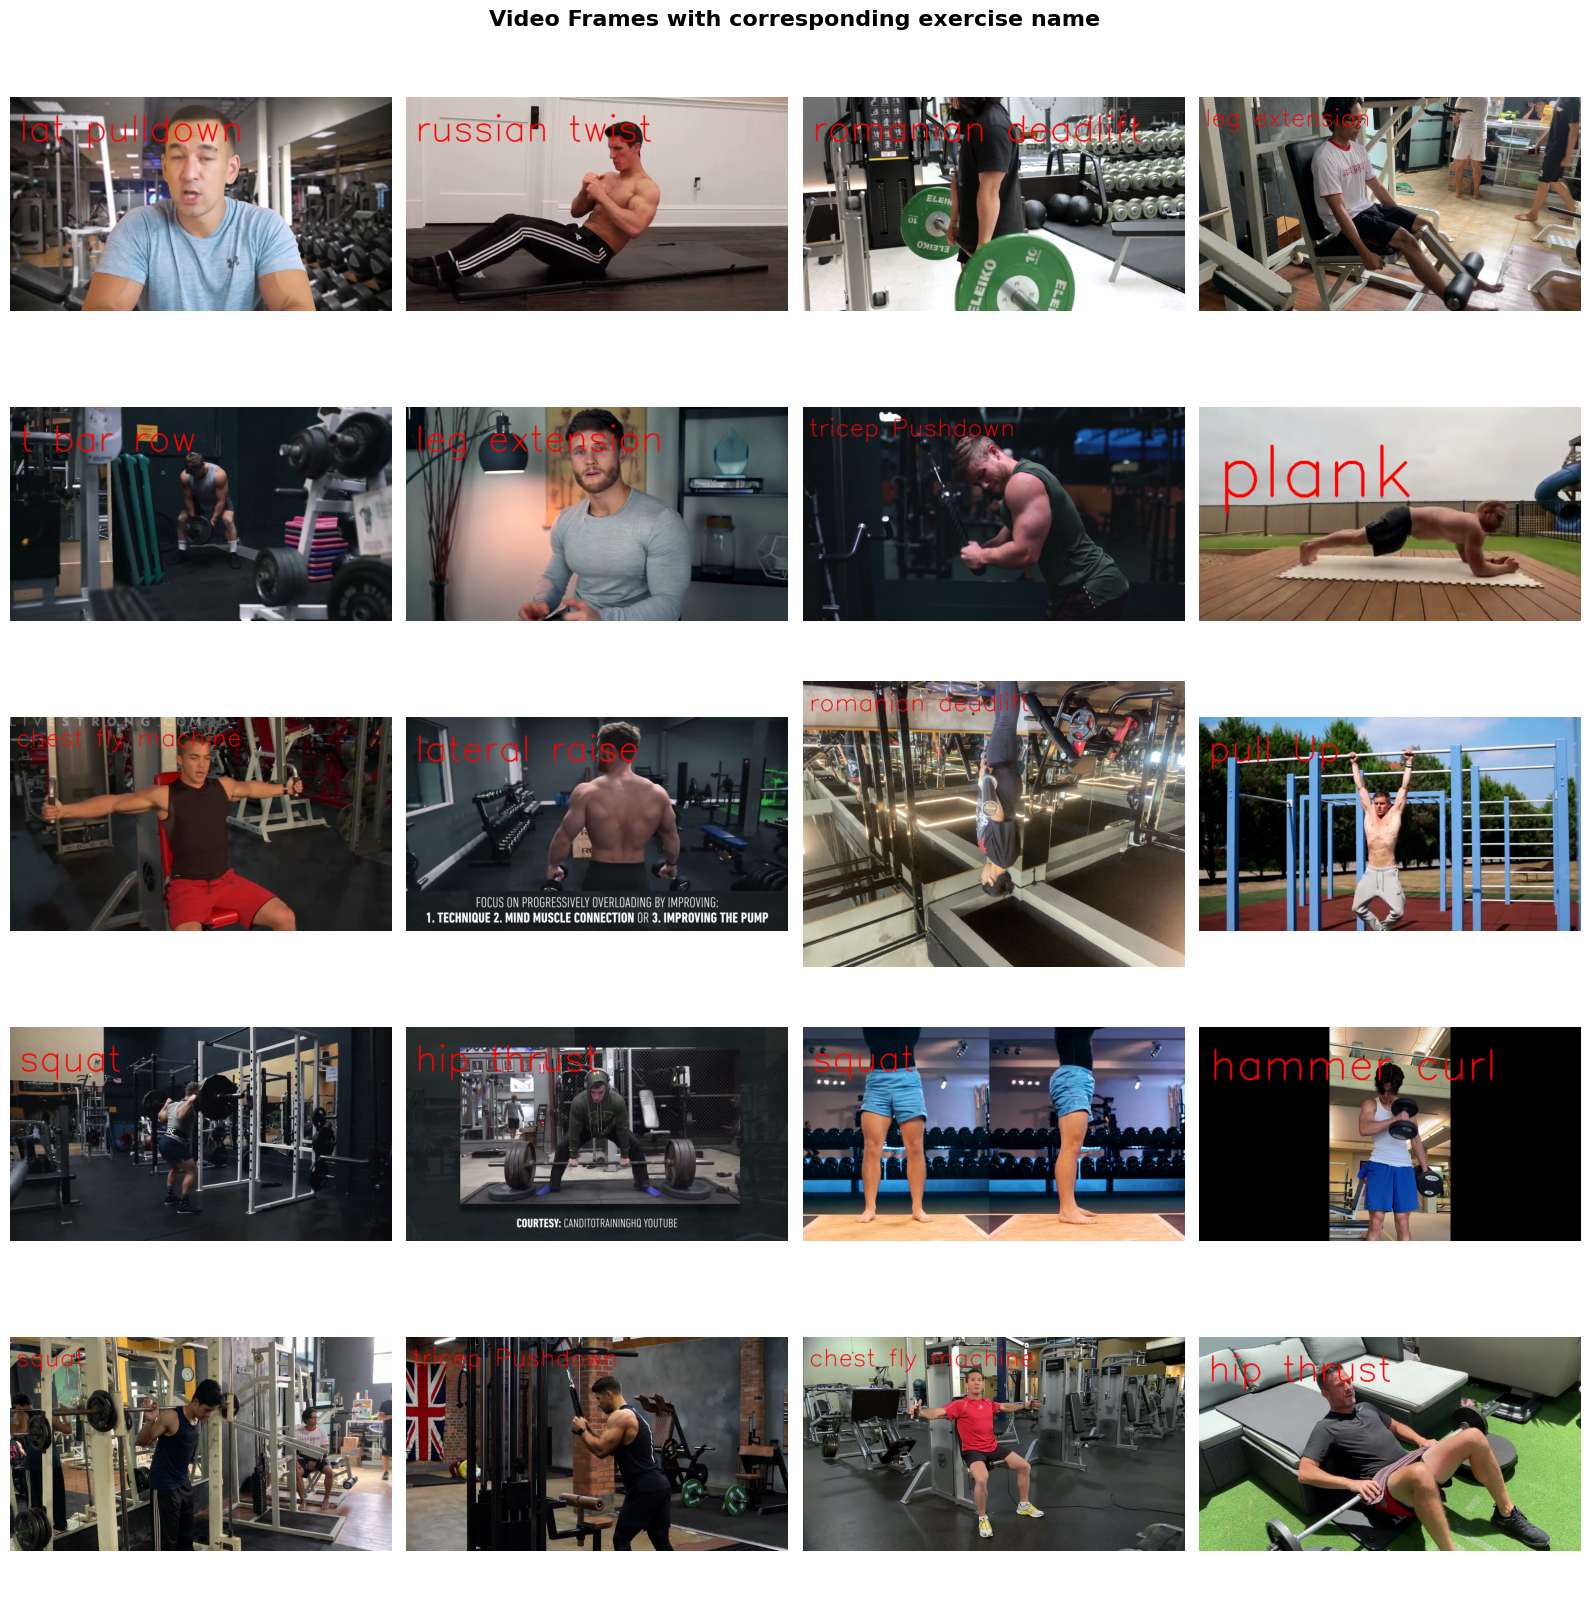

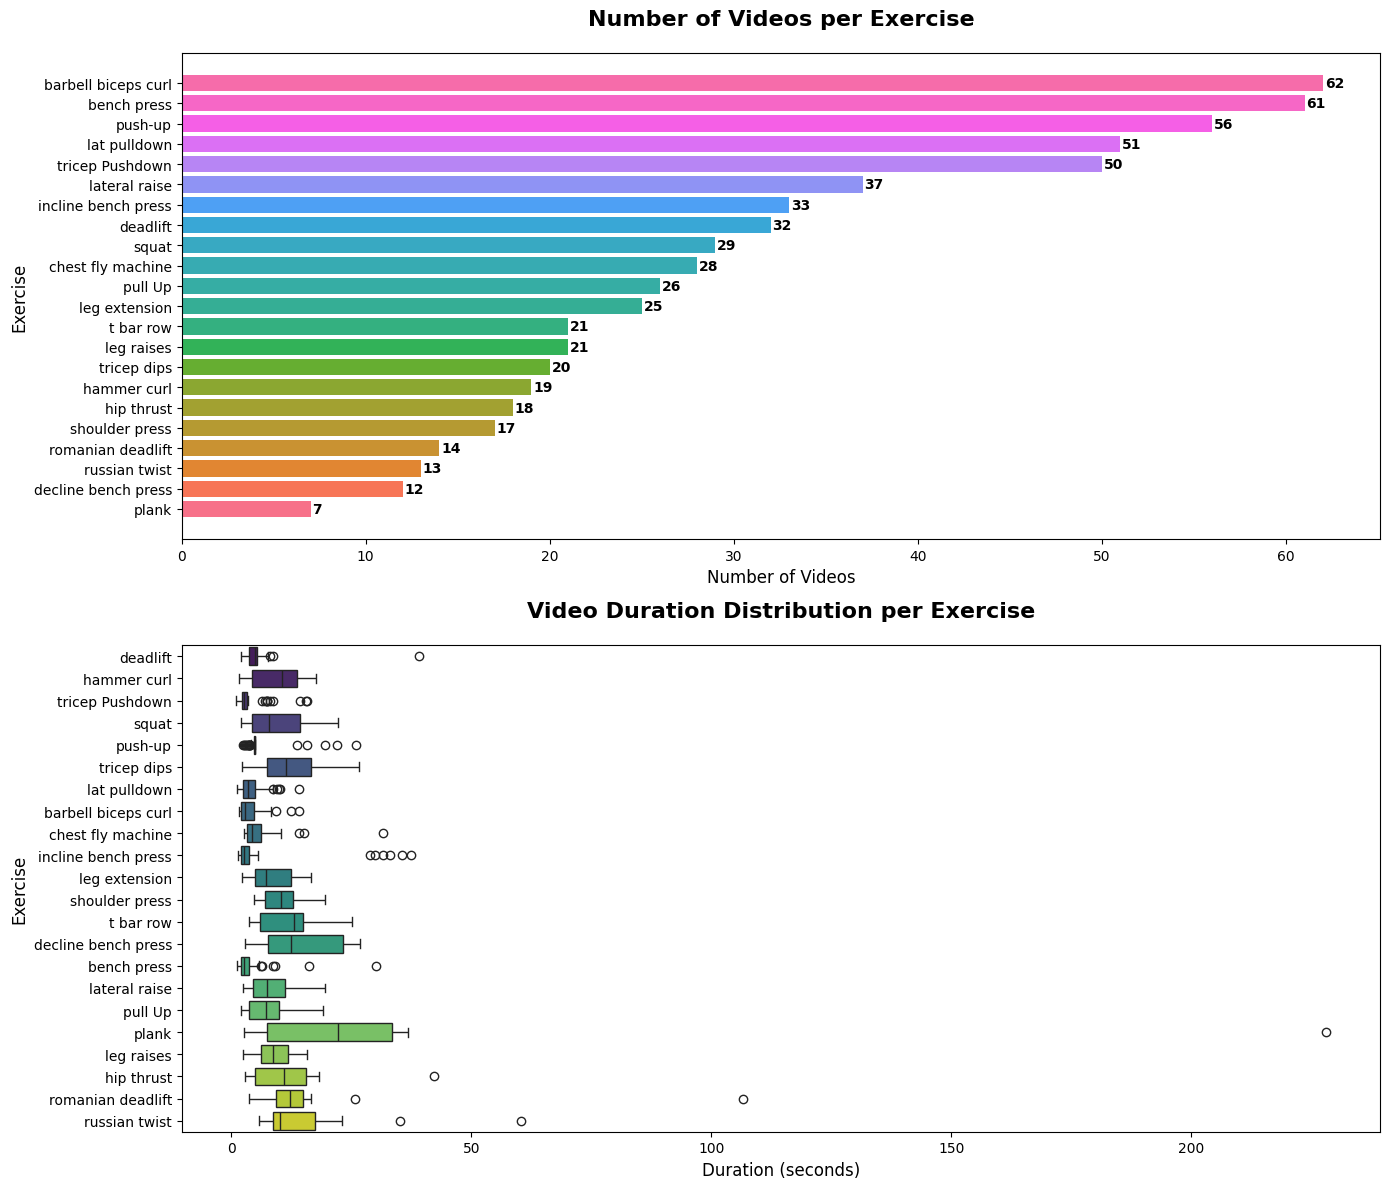

In [4]:
class VideoDatasetAnalyzer:
    def __init__(self, dataset_path):
        """
        Initialize the simplified video dataset analyzer
        """
        self.dataset_path = dataset_path
        self.video_extensions = ('.mp4', '.avi', '.mov', '.mkv', '.wmv', '.flv', '.MOV', '.MP4')
        self.video_data = []
        
    def get_video_duration(self, file_path):
        """
        Extract video duration
        """
        try:
            cap = cv2.VideoCapture(file_path)
            
            if not cap.isOpened():
                return 0
            
            fps = cap.get(cv2.CAP_PROP_FPS)
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            duration = frame_count / fps if fps > 0 else 0
            
            cap.release()
            return round(duration, 2)
            
        except Exception as e:
            return 0
    
    def analyze_dataset(self):
        """
        Analyze the dataset
        """
        if not os.path.exists(self.dataset_path):
            return
        
        # Get exercise folders
        exercise_folders = [f for f in os.listdir(self.dataset_path) 
                          if os.path.isdir(os.path.join(self.dataset_path, f))]
        
        # Get video files
        for exercise_folder in exercise_folders:
            folder_path = os.path.join(self.dataset_path, exercise_folder)
            
            video_files = [f for f in os.listdir(folder_path) 
                          if f.lower().endswith(self.video_extensions)] 
            
            # Get video duration
            for video_file in video_files:
                video_path = os.path.join(folder_path, video_file)
                
                duration = self.get_video_duration(video_path)
                
                self.video_data.append({
                    'Exercise': exercise_folder,
                    'Video_Name': video_file,
                    'Duration_Seconds': duration
                })
    
    def create_visualizations(self, save_path=None):
        """
        Create visualizations:
        - Number of videos per exercise
        - Video duration distribution per exercise
        """
        if not self.video_data:
            print("No video data available")
            return
        
        # Create DataFrame
        df = pd.DataFrame(self.video_data)
        
        # Create visualizations
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
        
        # Plot Number of videos per exercise
        count_data = df['Exercise'].value_counts().sort_values(ascending=True)
        bars = ax1.barh(count_data.index, count_data.values, color=sns.color_palette("husl", len(count_data)))
        ax1.set_title('Number of Videos per Exercise', fontsize=16, fontweight='bold', pad=20)
        ax1.set_xlabel('Number of Videos', fontsize=12)
        ax1.set_ylabel('Exercise', fontsize=12)
        
        # Add value labels on bars
        for i, (bar, count) in enumerate(zip(bars, count_data.values)):
            ax1.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                    f'{int(count)}', ha='left', va='center', fontweight='bold')
        
        # Plot Video durations distribution per exercise (boxplot)
        sns.boxplot(data=df, x='Duration_Seconds', y='Exercise', ax=ax2, palette='viridis')
        ax2.set_title('Video Duration Distribution per Exercise', fontsize=16, fontweight='bold', pad=20)
        ax2.set_xlabel('Duration (seconds)', fontsize=12)
        ax2.set_ylabel('Exercise', fontsize=12)
        
        plt.style.use('default')
        sns.set_palette("husl")
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
    
    def plot_random_video_frames(self, n_rows=5, n_cols=4, figsize=(16, 16)):
        """
        Display a grid of first frames from randomly chosen videos from the dataset.
        """
        exercise_folders = [f for f in os.listdir(self.dataset_path)
                            if os.path.isdir(os.path.join(self.dataset_path, f))]
        
        plt.figure(figsize=figsize)
        plt.title('Video Frames with corresponding exercise name', fontsize=16, fontweight='bold', pad=10)
        plt.axis('off')
        filled = 0
        attempts = 0
        max_attempts = n_rows * n_cols
        
        while filled < n_rows * n_cols and attempts < max_attempts:
            
            attempts += 1
            class_name = random.choice(exercise_folders)
            class_path = os.path.join(self.dataset_path, class_name)
            video_files = [f for f in os.listdir(class_path)
                        if f.lower().endswith(self.video_extensions)]
            if not video_files:
                continue
            
            video_file = random.choice(video_files)
            video_path = os.path.join(class_path, video_file)
            cap = cv2.VideoCapture(video_path)
            ret, frame = cap.read()
            cap.release()
            if not ret or frame is None:
                continue
            
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            cv2.putText(rgb_frame, class_name, (30, 150), cv2.FONT_HERSHEY_SIMPLEX,
                        4, (255, 0, 0), 3, cv2.LINE_AA)
            filled += 1
            plt.subplot(n_rows, n_cols, filled)
            plt.imshow(rgb_frame)
            plt.axis('off')
            
        plt.tight_layout()
        plt.show()

# Init analyzer with dataset path
analyzer = VideoDatasetAnalyzer('dataset')

# Analyze and visualize dataset
analyzer.analyze_dataset()

# Calculate average video duration
df = pd.DataFrame(analyzer.video_data)
average_duration = df['Duration_Seconds'].mean()
number_of_videos = len(df)
print(f"Average video duration: {average_duration:.2f} seconds")
print(f"Number of videos: {number_of_videos}")

# Show random video frames and visualizations
analyzer.plot_random_video_frames()
analyzer.create_visualizations()

### 1. Dataset Overview

- **Number of exercises:** 22
- **Total videos:** 652
- **Dataset structure:** Each folder represents a unique exercise class. Each folder contains video clips of a person performing the corresponding exercise.

### 2. Video Count per Exercise

- The dataset is somewhat imbalanced, with certain exercises like **barbell biceps curl** (62 videos), **bench press** (61 videos) having the highest number of samples, while **plank** (7 videos) and **decline bench press** (12 videos) have significantly fewer examples.

### 3. Video Duration Analysis

- The **average video duration** is **7.86 seconds**.
- Video durations vary widely both within and across exercises, with some outliers over even 50 seconds.
- Most videos are relatively short, typically under 60 seconds.

### 4. Potential Challenges

- **Class imbalance:** Some exercises are underrepresented, which may affect the performance of a classification model.
- **Variable video length:** Large differences in video duration could cause issues during preprocessing.
- **Visual diversity:** Differences in lighting, camera angle, and gym environment may add complexity to recognition tasks.



## Method 1

### Preprocessing

**What this step does:**

- Converts each workout video into a series of individual frame images, organized by exercise class.

**The cell does the following:**

- Loops over every video in the dataset, organized by exercise type (one folder per exercise).
- Extracts up to `FRAMES_PER_VIDEO` frames evenly spaced throughout each video.
- Saves each frame as a `.jpg` image in a class-specific subfolder.

**Final output:**

- Creates a new folder structure (`./dataset_frames`) where:
    - Each exercise has its own folder.
    - Each frame is saved as a separate `.jpg` file, ready for use in standard image classification tasks or transfer learning pipelines (e.g., with CNNs or Vision Transformers).


In [5]:
VIDEO_DIR = './dataset'
OUTPUT_DIR = './dataset_frames'
FRAMES_PER_VIDEO = 10

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Extract frames
for exercise in os.listdir(VIDEO_DIR):
    exercise_path = os.path.join(VIDEO_DIR, exercise)
    if not os.path.isdir(exercise_path):
        continue
    out_folder = os.path.join(OUTPUT_DIR, exercise)
    os.makedirs(out_folder, exist_ok=True)
    for video_file in tqdm.tqdm(os.listdir(exercise_path)):
        if not video_file.lower().endswith(('.mp4', '.avi', '.mov', '.mkv', '.wmv', '.flv', '.MOV', '.MP4')):
            continue
        # Check if frames for this video already exist
        frames_exist = all(
            os.path.exists(os.path.join(
                out_folder, f"{os.path.splitext(video_file)[0]}_frame{i}.jpg"
            )) for i in range(FRAMES_PER_VIDEO)
        )
        if frames_exist:
            continue

        video_path = os.path.join(exercise_path, video_file)
        cap = cv2.VideoCapture(video_path)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frames_to_extract = min(FRAMES_PER_VIDEO, frame_count)
        step = frame_count // frames_to_extract if frames_to_extract > 0 else 1
        for i in range(frames_to_extract):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
            ret, frame = cap.read()
            if ret:
                out_name = f"{os.path.splitext(video_file)[0]}_frame{i}.jpg"
                out_path = os.path.join(out_folder, out_name)
                cv2.imwrite(out_path, frame)
        cap.release()
print("Done extracting frames!")

100%|██████████| 13/13 [00:06<00:00,  1.88it/s]

Done extracting frames!


### Before We Build the Models …

The dataset is **imbalanced**—some exercises have far more clips than others. If we train “as is,” a classifier will focus on those majority classes and under-perform on the rarer ones.

**Cross-entropy loss**  
Measures the gap between true labels and predicted probabilities. Works well on balanced data, but it **weights every class equally**.

**Focal loss**  
Adds a modulating term to cross-entropy that **down-weights easy, already-correct predictions** and **up-weights hard, misclassified ones**. This forces the network to spend more time on the minority classes.

**Why we switched to focal loss**  
Because our exercise counts vary widely, focal loss helps the network learn meaningful features for the underrepresented exercises.

*Implementation:* we use the PyTorch version from [clcarwin/focal_loss_pytorch](https://github.com/clcarwin/focal_loss_pytorch).


In [6]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean'):
        """
        Focal Loss for multi-class classification.
        Args:
            gamma (float): focusing parameter (default 2)
            alpha (list, float, or None): class weight(s)
            reduction (str): 'mean' | 'sum' | 'none'
        """
        super().__init__()
        self.gamma = gamma
        if alpha is not None:
            if isinstance(alpha, (float, int)):
                self.alpha = torch.tensor([alpha, 1 - alpha])
            else:
                self.alpha = torch.tensor(alpha)
        else:
            self.alpha = None
        self.reduction = reduction

    def forward(self, input, target):
        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1)
            input = input.transpose(1, 2)
            input = input.contiguous().view(-1, input.size(2))
        target = target.view(-1, 1)

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = logpt.exp()

        if self.alpha is not None:
            if self.alpha.device != input.device:
                self.alpha = self.alpha.to(input.device)
            at = self.alpha.gather(0, target.view(-1))
            logpt = logpt * at

        loss = -1 * (1 - pt) ** self.gamma * logpt
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


### Models:

#### SimpleCNN Model

**Overview**  
The `SimpleCNN` is a lightweight convolutional neural network. It uses a straightforward stack of convolutional, pooling, and fully connected layers for image-based classification.

**Key Components**

- **Input:**  
  Processes 3-channel color images (e.g., 224x224 RGB frames).

- **Convolutional Layers:**  
  Two consecutive 2D convolutional layers with 64 filters each extract visual features from input images, followed by batch normalization and ReLU activations for stability and non-linearity.

- **Pooling and Global Pooling:**  
  Max pooling reduces spatial dimensions, and global average pooling condenses each feature map into a single value, making the model more robust to spatial variations.

- **Fully Connected Layers:**  
  Features are passed through two dense layers, with batch normalization and ReLU in between, before producing the final class logits.

- **Loss Function:**  
  Focal Loss is used to address class imbalance in the dataset, focusing learning on harder or underrepresented examples.

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

def get_dataloaders(
    data_dir,
    transform,
    batch_size=32,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    num_workers=2,
    seed=42
):
    """
    Loads an ImageFolder dataset and returns train/val/test DataLoaders.

    Args:
        data_dir (str): Path to the image folder.
        transform: torchvision transforms to apply.
        batch_size (int): Batch size for DataLoaders.
        train_ratio (float): Proportion for training set.
        val_ratio (float): Proportion for validation set.
        test_ratio (float): Proportion for test set.
        num_workers (int): DataLoader workers.
        seed (int): Random seed for split reproducibility.

    Returns:
        train_loader, val_loader, test_loader, classes_list
    """
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    classes_list = dataset.classes

    total_len = len(dataset)
    train_len = int(train_ratio * total_len)
    val_len = int(val_ratio * total_len)
    test_len = total_len - train_len - val_len

    generator = torch.Generator().manual_seed(seed)
    train_ds, val_ds, test_ds = random_split(
        dataset, [train_len, val_len, test_len], generator=generator
    )

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader, classes_list

In [8]:
transform_cnn = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_loader_cnn, val_loader_cnn, test_loader_cnn, classes_list = get_dataloaders(
    data_dir='dataset_frames',
    transform=transform_cnn,
    batch_size=32,
    num_workers=2
)


In [9]:
class SimpleCNN(pl.LightningModule):
    def __init__(self, num_classes, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(64, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, num_classes)
        self.lr = lr
        self.criterion = FocalLoss(gamma=3, alpha=None)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.bn1(x)
        x = self.pool(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)   # Flatten
        x = F.relu(self.fc1(x))
        x = self.bn2(x)
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = self.criterion(logits, labels)
        acc = (logits.argmax(dim=1) == labels).float().mean()
        self.log("train_loss", loss)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = self.criterion(logits, labels)
        acc = (logits.argmax(dim=1) == labels).float().mean()
        self.log("val_loss", loss)
        self.log("val_acc", acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = self.criterion(logits, labels)
        acc = (logits.argmax(dim=1) == labels).float().mean()
        self.log("test_loss", loss)
        self.log("test_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [12]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

model = SimpleCNN(num_classes=len(classes_list), lr=1e-3)

checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    save_top_k=1,
    mode='max',
    filename='best-simplecnn-{epoch:02d}-{val_acc:.4f}',
    dirpath='checkpoints'
)

trainer = pl.Trainer(
    max_epochs=50,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5),
        checkpoint_callback
    ],
    accelerator="auto",
    devices="auto"
)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [13]:
trainer.fit(model, train_loader_cnn, val_loader_cnn)
trainer.test(model, test_loader_cnn)
print("Best model saved at:", checkpoint_callback.best_model_path)


  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | conv1     | Conv2d            | 1.8 K  | train
1 | conv2     | Conv2d            | 36.9 K | train
2 | bn1       | BatchNorm2d       | 128    | train
3 | pool      | MaxPool2d         | 0      | train
4 | gap       | AdaptiveAvgPool2d | 0      | train
5 | fc1       | Linear            | 16.6 K | train
6 | bn2       | BatchNorm1d       | 512    | train
7 | fc2       | Linear            | 5.7 K  | train
8 | criterion | FocalLoss         | 0      | train
--------------------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Testing DataLoader 0: 100%|██████████| 31/31 [00:05<00:00,  5.55it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8762781023979187     │
│         test_loss         │    0.1851155310869217     │
└───────────────────────────┴───────────────────────────┘

Best model saved at: /Users/tamir_gez/Documents/PythonProjects/WorkoutClassifier/checkpoints/best-simplecnn-epoch=22-val_acc=0.9826.ckpt


##### Model Evaluation: Test Set Results

In [14]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from typing import Union

def evaluate_model(
    model_or_class: Union[torch.nn.Module, type],
    test_loader,
    class_names,
    device,
    title="Confusion Matrix - Test Set",
    checkpoint_path=None,
    input_type=None
):
    """
    General evaluation function for image-based and pose-based models.

    Args:
        model_or_class: Either a model class (for loading from checkpoint) or an instantiated model.
        test_loader: DataLoader yielding batches:
            - (images, labels) for image models
            - (poses, velocities, confidences, labels) for pose models
        class_names: List of class names.
        device: 'cuda' | 'mps' | 'cpu'.
        title: Plot title.
        checkpoint_path: If loading from checkpoint, provide the path. If None, model_or_class is used as is.
        input_type: 'image', 'pose', or None (auto-detect from batch length).
    """
    # Load model if class & checkpoint are given
    if checkpoint_path is not None and isinstance(model_or_class, type):
        model = model_or_class.load_from_checkpoint(checkpoint_path, num_classes=len(class_names))
    else:
        model = model_or_class
    model = model.to(device)
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            # Determine input type
            batch = [x.to(device) for x in batch]
            use_input_type = input_type
            if use_input_type is None:
                if len(batch) == 2:
                    use_input_type = 'image'
                elif len(batch) == 4:
                    use_input_type = 'pose'
                else:
                    raise ValueError(f"Unsupported batch size: {len(batch)}")
            # Forward pass based on input type
            if use_input_type == 'image':
                images, labels = batch
                logits = model(images)
            elif use_input_type == 'pose':
                poses, velocities, confidences, labels = batch
                logits = model(poses, velocities, confidences)
            else:
                raise ValueError(f"Unknown input_type '{use_input_type}'")

            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=2))

    fig, ax = plt.subplots(figsize=(16, 14))
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        xticks_rotation=45,
        ax=ax
    )
    plt.title(title, fontsize=20)
    plt.tight_layout()
    plt.show()



Classification Report:
                     precision    recall  f1-score   support

barbell biceps curl       1.00      0.99      0.99        94
        bench press       0.91      0.98      0.94        86
  chest fly machine       1.00      1.00      1.00        48
           deadlift       0.95      0.95      0.95        55
decline bench press       1.00      0.91      0.95        22
        hammer curl       0.97      1.00      0.98        29
         hip thrust       1.00      0.89      0.94        28
incline bench press       0.98      1.00      0.99        59
       lat pulldown       1.00      1.00      1.00        82
      lateral raise       0.88      0.97      0.93        38
      leg extension       1.00      1.00      1.00        32
         leg raises       1.00      1.00      1.00        28
              plank       0.73      0.89      0.80         9
            pull Up       1.00      0.93      0.97        46
            push-up       1.00      1.00      1.00        69

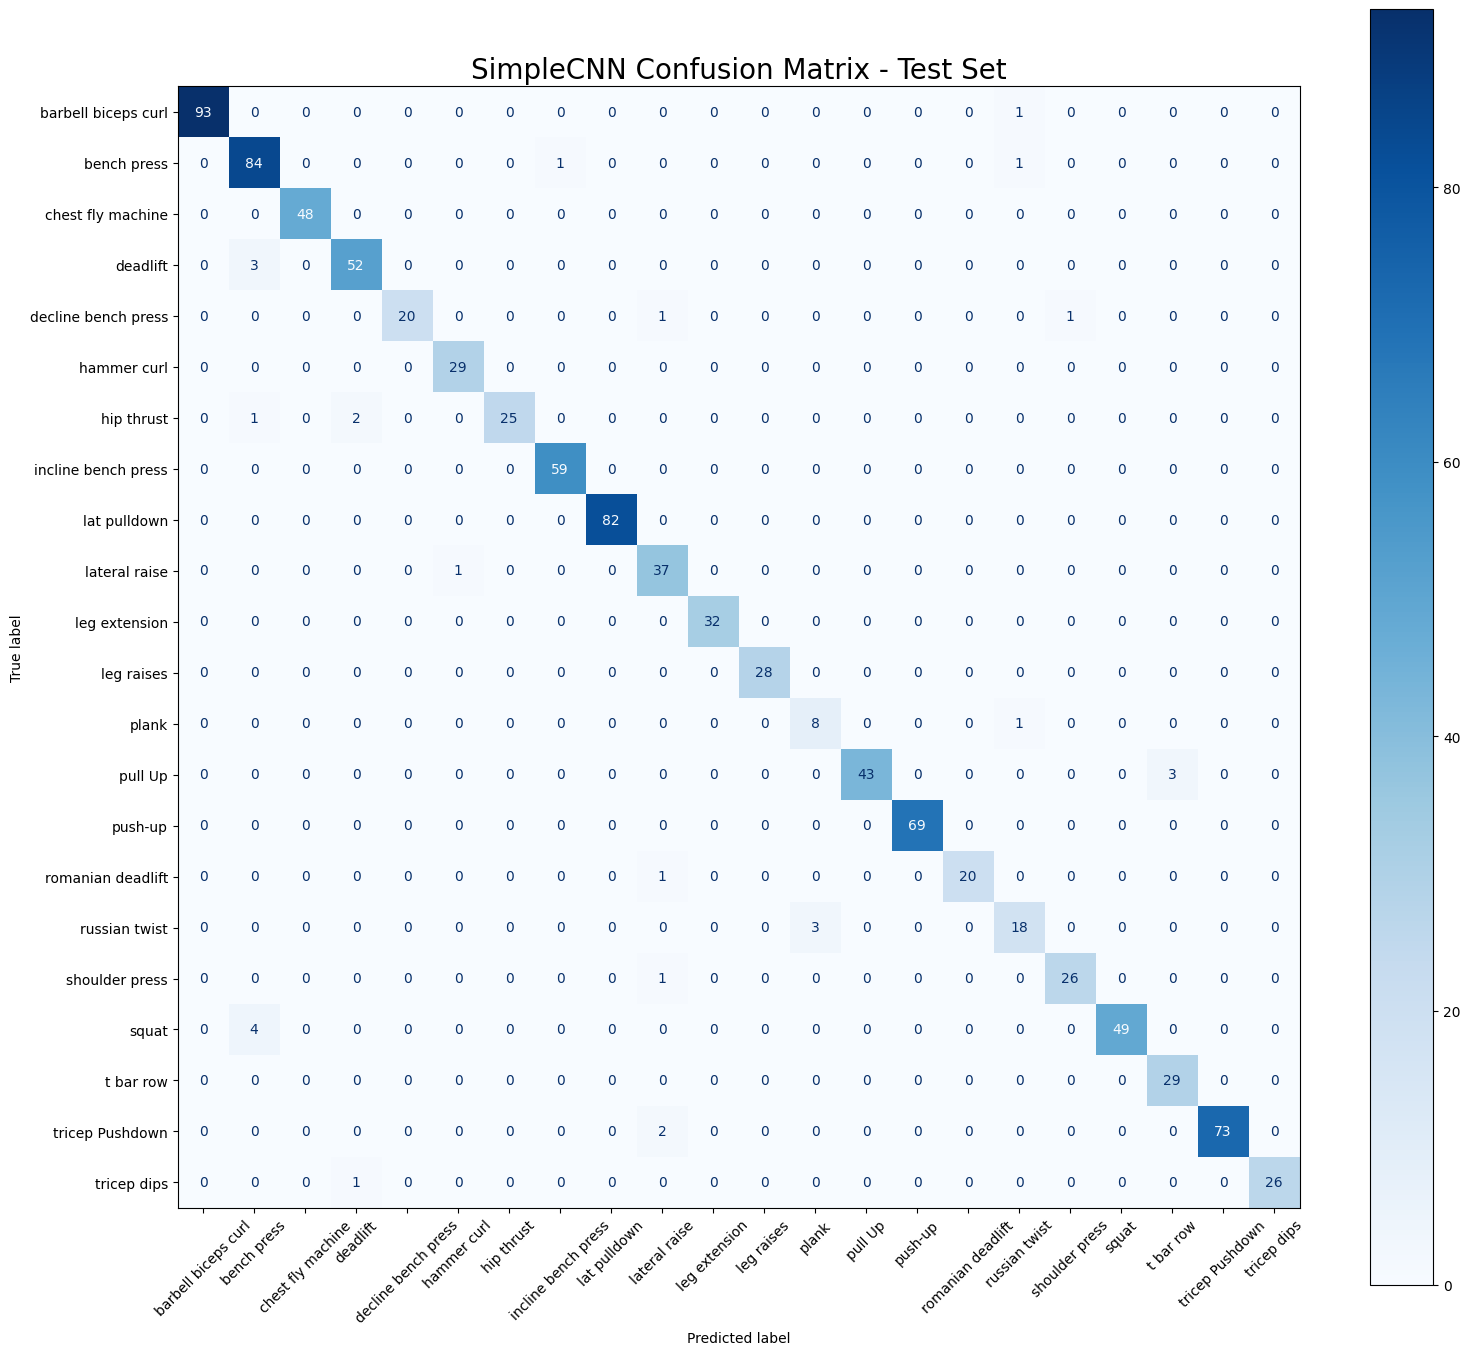

In [15]:
evaluate_model(
    model_or_class=SimpleCNN,
    checkpoint_path=checkpoint_callback.best_model_path,
    test_loader=test_loader_cnn,
    class_names=classes_list,
    device=device,
    title="SimpleCNN Confusion Matrix - Test Set"
)

##### Results:

Our model achieved excellent performance on the test set, with an overall accuracy of **~89%**.


#### ViTClassifier Model

**Overview**
- The ViTClassifier is a Vision Transformer (ViT) model for image classification. It uses a pretrained transformer (ViT-B/16).

**Key Components**

- **Input:**
Processes 3-channel color images, resized to 224x224 (RGB frames).

- **Pretrained Vision Transformer Backbone:**
Uses a pretrained ViT-B/16 model from torchvision.

- **Classification Head:**
The final fully connected layer ("head") is replaced with a new linear layer matching the number of output classes in the dataset.

- **Loss Function:**
The model uses Focal Loss as the rest of the models.

- **Transfer Learning:**
By initializing with pretrained weights, the model benefits from prior learning on large datasets (e.g., ImageNet), enabling faster convergence and better performance on smaller, domain-specific datasets.

In [16]:
transform_vit = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalization
])

train_loader_vit, val_loader_vit, test_loader_vit, classes_list = get_dataloaders(
    data_dir='dataset_frames',
    transform=transform_vit,
    batch_size=32,
    num_workers=0
)

In [17]:
from torchvision import models

class ViTClassifier(pl.LightningModule):
    def __init__(self, num_classes, lr=3e-4):
        super().__init__()
        self.save_hyperparameters()
        
        # Load pretrained ViT
        self.vit = models.vit_b_16(pretrained=True)
        
        # Replace the head for your number of classes
        in_features = self.vit.heads.head.in_features
        self.vit.heads.head = nn.Linear(in_features, num_classes)
        self.criterion = FocalLoss(gamma=2, alpha=None)
        self.lr = lr

    def forward(self, x):
        return self.vit(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = self.criterion(logits, labels)
        acc = (logits.argmax(dim=1) == labels).float().mean()
        self.log('train_loss', loss)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = self.criterion(logits, labels)
        acc = (logits.argmax(dim=1) == labels).float().mean()
        self.log('val_loss', loss)
        self.log('val_acc', acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = self.criterion(logits, labels)
        acc = (logits.argmax(dim=1) == labels).float().mean()
        self.log('test_loss', loss)
        self.log('test_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer


In [18]:
model = ViTClassifier(num_classes=len(classes_list))

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    save_top_k=1,
    mode='min',
    filename='best-vit-{epoch:02d}-{val_loss:.4f}',
    dirpath='checkpoints'
)

trainer = pl.Trainer(
    max_epochs=20,
    callbacks=[checkpoint_callback, pl.callbacks.EarlyStopping('val_loss', patience=5)],
    accelerator="auto",
    devices="auto",
    log_every_n_steps=10
)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [19]:
trainer.fit(model, train_loader_vit, val_loader_vit)
trainer.test(model, test_loader_vit)

print("Best model saved at:", checkpoint_callback.best_model_path)


  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | vit       | VisionTransformer | 85.8 M | train
1 | criterion | FocalLoss         | 0      | train
--------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.262   Total estimated model params size (MB)
153       Modules in train mode
0         Modules in eval mode


Testing DataLoader 0: 100%|██████████| 31/31 [00:14<00:00,  2.09it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9846625924110413     │
│         test_loss         │   0.027494745329022408    │
└───────────────────────────┴───────────────────────────┘

Best model saved at: /Users/tamir_gez/Documents/PythonProjects/WorkoutClassifier/checkpoints/best-vit-epoch=13-val_loss=0.0375.ckpt



Classification Report:
                     precision    recall  f1-score   support

barbell biceps curl       0.98      1.00      0.99        94
        bench press       0.99      0.97      0.98        86
  chest fly machine       0.98      1.00      0.99        48
           deadlift       0.96      1.00      0.98        55
decline bench press       1.00      0.95      0.98        22
        hammer curl       1.00      1.00      1.00        29
         hip thrust       1.00      0.93      0.96        28
incline bench press       0.95      0.98      0.97        59
       lat pulldown       1.00      1.00      1.00        82
      lateral raise       0.97      0.97      0.97        38
      leg extension       1.00      1.00      1.00        32
         leg raises       1.00      1.00      1.00        28
              plank       0.73      0.89      0.80         9
            pull Up       1.00      0.98      0.99        46
            push-up       0.97      1.00      0.99        69

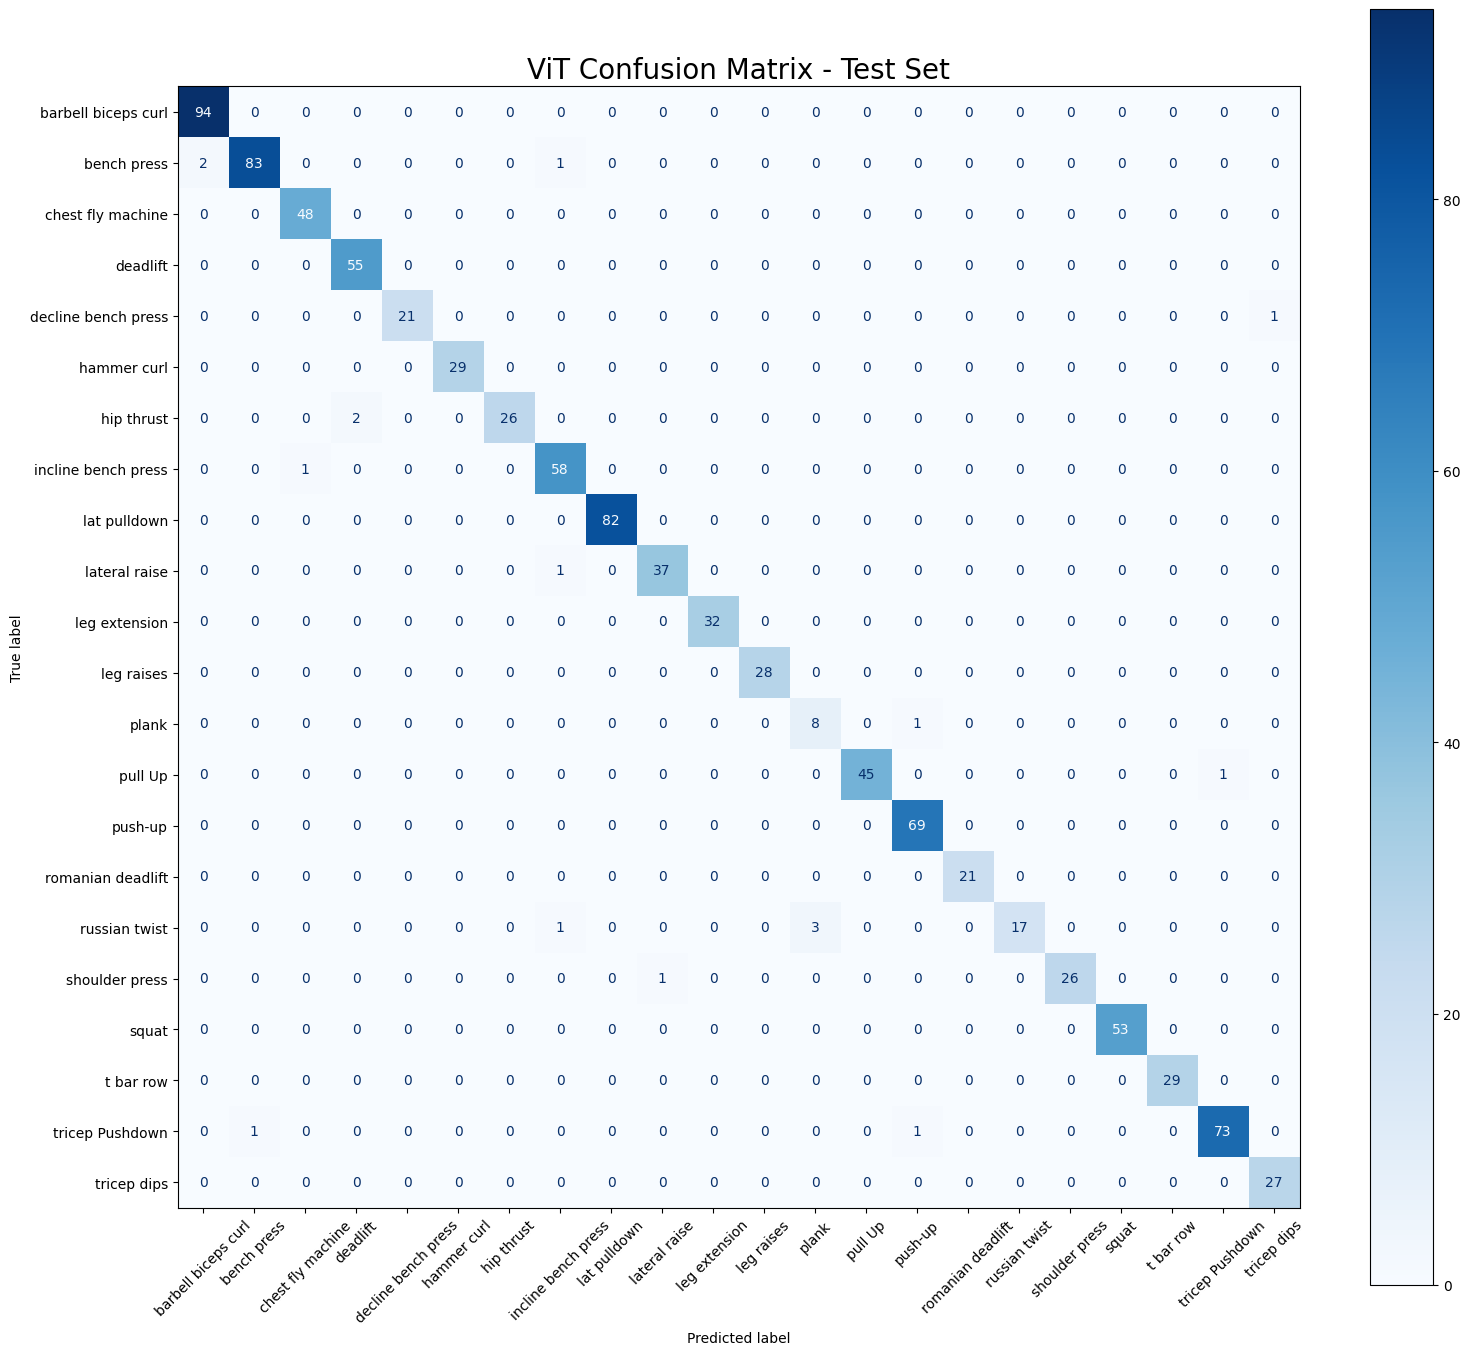

In [20]:
evaluate_model(
    model_or_class=ViTClassifier,
    checkpoint_path=checkpoint_callback.best_model_path,
    test_loader=test_loader_vit,
    class_names=classes_list,
    device=device,
    title="ViT Confusion Matrix - Test Set"
)

##### Results:

The `ViTClassifier` model achieved a performance of **~98%** on the test set.

In [21]:
# Load the best model and saves it
best_model = ViTClassifier.load_from_checkpoint(
    checkpoint_callback.best_model_path,  
    num_classes=len(classes_list)
)

torch.save(best_model.state_dict(), "vit_classifier_weights.pth")

## Method 2

### Preprocessing

**What this step does:**

- Turns raw workout videos into organized, ready-to-use data for training a model.

**The cell does the following:**

- Extracts body landmarks from each video using [MediaPipe pose estimation](https://ai.google.dev/edge/mediapipe/solutions/vision/pose_landmarker) (see the landmark diagram below).
- Normalizes poses so all samples are centered on the hips.
- Calculates movement (velocity) for every landmark between frames.
- Computes confidence scores for how visible each landmark is.
- Addiation data augmentation to double the dataset and help the model generalize.

**Final output:**

- Saves `.npy` files containing:
- `X.npy`: Normalized poses + velocities + weighted confidences for every frame and sample.

- `y.npy`: Numeric exercise labels for each sample.

- `confidences.npy`: Average per-video confidence score.

- `class_mapping.npy`: Mapping from exercise name to numeric label.

- `skipped_files.txt`: Skipped/failed video file paths.


<img src="https://ai.google.dev/static/mediapipe/images/solutions/pose_landmarks_index.png" width="500" height="500"/>


In [22]:
# Define landmark groups
LANDMARK_GROUPS = {
    'arms': [11,12,13,14,15,16],  # shoulder to wrist landmarks
    'legs': [23,24,25,26,27,28],  # hip to ankle landmarks
    'core': [23,24,11,12],  # hips and shoulders
    'upper_body': [11,12,13,14,15,16,0,1,2,3,4,5,6,7,8,9,10]  # above hips
}

# Different weights for different exercises
EXERCISE_WEIGHTS = {
    'bench press': {'arms': 0.5, 'core': 0.3, 'legs': 0.2},
    'barbell biceps curl': {'arms': 0.7, 'core': 0.2, 'legs': 0.1},
    'chest fly machine': {'arms': 0.5, 'core': 0.4, 'legs': 0.1},
    'deadlift': {'legs': 0.4, 'core': 0.4, 'arms': 0.2},
    'decline bench press': {'arms': 0.5, 'core': 0.3, 'legs': 0.2},
    'hammer curl': {'arms': 0.7, 'core': 0.2, 'legs': 0.1},
    'hip thrust': {'legs': 0.5, 'core': 0.4, 'arms': 0.1},
    'incline bench press': {'arms': 0.5, 'core': 0.3, 'legs': 0.2},
    'lat pulldown': {'arms': 0.5, 'core': 0.4, 'legs': 0.1},
    'lateral raise': {'arms': 0.6, 'core': 0.3, 'legs': 0.1},
    'leg extension': {'legs': 0.7, 'core': 0.2, 'arms': 0.1},
    'leg raises': {'core': 0.6, 'legs': 0.3, 'arms': 0.1},
    'plank': {'core': 0.7, 'arms': 0.2, 'legs': 0.1},
    'pull Up': {'arms': 0.5, 'core': 0.4, 'legs': 0.1},
    'push-up': {'arms': 0.5, 'core': 0.4, 'legs': 0.1},
    'romanian deadlift': {'legs': 0.5, 'core': 0.3, 'arms': 0.2},
    'russian twist': {'core': 0.6, 'arms': 0.2, 'legs': 0.2},
    'shoulder press': {'arms': 0.6, 'core': 0.3, 'legs': 0.1},
    'squat': {'legs': 0.6, 'core': 0.3, 'arms': 0.1},
    't bar row': {'arms': 0.4, 'core': 0.4, 'legs': 0.2},
    'tricep dips': {'arms': 0.6, 'core': 0.3, 'legs': 0.1},
    'tricep Pushdown': {'arms': 0.7, 'core': 0.2, 'legs': 0.1}
}

class WorkoutDataPreparator:
    def __init__(self, base_folder, target_classes=None, max_frames=45):
        self.base_folder = base_folder
        self.target_classes = target_classes
        self.max_frames = max_frames
        self.mp_pose = mp.solutions.pose # Google's MediaPipe for pose estimation
        self.pose = self.mp_pose.Pose(
            static_image_mode=False,
            model_complexity=2,
            min_detection_confidence=0.5
        )

    def calculate_weighted_confidence(self, landmarks, exercise_type):
        """
        Calculate weighted confidence scores for each landmark
        """
        weights = EXERCISE_WEIGHTS[exercise_type]
        weighted_scores = np.zeros(33)  # One score per landmark
        
        for group, weight in weights.items():
            group_landmarks = LANDMARK_GROUPS[group]
            for lm_idx in group_landmarks:
                weighted_scores[lm_idx] = landmarks[lm_idx].visibility * weight
                
        return weighted_scores
    
    def normalize_poses(self, poses):
        """
        Normalize poses by centering on hip center
        Ensure the pose data is not affected by the person's position in the frame
        """
        poses = torch.tensor(poses, dtype=torch.float32).to(device)
        landmarks = poses.view(-1, 33, 4) # (frames, 33, 4) -> 4 = x,y,z,visibility

        left_hip = landmarks[:, 23, :3] 
        right_hip = landmarks[:, 24, :3]
        hip_center = (left_hip + right_hip) / 2

        landmarks[:, :, :3] -= hip_center.unsqueeze(1) # technique to subtract the hip center from the landmarks 
        return landmarks.view(poses.shape[0], -1).cpu().numpy() # [45, 33, 4] -> [45, 132]

    def calculate_velocity(self, poses):
        """
        Calculate velocity features
        """
        poses = torch.tensor(poses, dtype=torch.float32).to(device)
        velocity = torch.zeros_like(poses)
        velocity[1:] = poses[1:] - poses[:-1]
        return velocity.cpu().numpy()

    def extract_poses_from_video(self, video_path, exercise_type=None, no_type=False):
        """
        Extract pose features from a video file using MediaPipe pose estimation.
        By default, uses exercise_type for weighted confidences.
        If no_type=True, sets weighted confidences to zeros, ignoring exercise_type.
        """
        poses = []
        confidence_scores = []
        weighted_confidences = []

        try:
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                raise ValueError(f"Could not open video file: {video_path}")

            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            frame_indices = np.linspace(0, total_frames-1, self.max_frames, dtype=int)

            for frame_idx in frame_indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                ret, frame = cap.read()
                if not ret:
                    break

                frame = cv2.resize(frame, (640, 480))
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                results = self.pose.process(frame_rgb)

                if results.pose_landmarks:
                    confidence = np.mean([lm.visibility for lm in results.pose_landmarks.landmark])

                    if no_type:
                        weighted_conf = np.zeros(33)
                    else:
                        # This will throw an error if exercise_type is None and no_type is False (which is correct!)
                        weighted_conf = self.calculate_weighted_confidence(
                            results.pose_landmarks.landmark, 
                            exercise_type
                        )

                    if confidence > 0.4:
                        landmarks = np.array([[lm.x, lm.y, lm.z, lm.visibility] 
                                            for lm in results.pose_landmarks.landmark])
                        poses.append(landmarks.flatten())
                        confidence_scores.append(confidence)
                        weighted_confidences.append(weighted_conf)
                else:
                    poses.append(np.zeros(33 * 4))
                    confidence_scores.append(0.0)
                    weighted_confidences.append(np.zeros(33))

            cap.release()

            if len(poses) < self.max_frames:
                last_pose = poses[-1] if poses else np.zeros(33 * 4)
                last_weighted_conf = weighted_confidences[-1] if weighted_confidences else np.zeros(33)
                poses.extend([last_pose] * (self.max_frames - len(poses)))
                confidence_scores.extend([0.0] * (self.max_frames - len(confidence_scores)))
                weighted_confidences.extend([last_weighted_conf] * (self.max_frames - len(weighted_confidences)))

            poses = np.array(poses)
            normalized_poses = self.normalize_poses(poses)
            velocity_features = self.calculate_velocity(normalized_poses)
            weighted_conf_features = np.array(weighted_confidences)

            final_poses = np.concatenate([normalized_poses, velocity_features, weighted_conf_features], axis=1)
            return final_poses, np.array(confidence_scores)

        except Exception as e:
            print(f"Error processing video {video_path}: {str(e)}")
            return np.zeros((self.max_frames, 297)), np.zeros(self.max_frames)


    def mirror_augment(self, poses):
        """
        Mirror augmentations
        """
        mirrored = poses.copy()
        orig_poses = mirrored[:, :33*4]
        velocity = mirrored[:, 33*4:33*8]
        weighted_conf = mirrored[:, 33*8:]

        # Mirror pose landmarks
        landmarks = orig_poses.reshape(-1, 33, 4)
        landmarks[:, :, 0] = 1 - landmarks[:, :, 0]
        pairs = [(1,2), (3,4), (5,6), (7,8), (9,10), (11,12), (13,14), (15,16),
                (23,24), (25,26), (27,28), (29,30), (31,32)]
        for pair in pairs:
            landmarks[:, [pair[0], pair[1]]] = landmarks[:, [pair[1], pair[0]]]
            weighted_conf[:, [pair[0], pair[1]]] = weighted_conf[:, [pair[1], pair[0]]]

        # Mirror velocity
        vel_landmarks = velocity.reshape(-1, 33, 4)
        vel_landmarks[:, :, 0] *= -1
        for pair in pairs:
            vel_landmarks[:, [pair[0], pair[1]]] = vel_landmarks[:, [pair[1], pair[0]]]

        # Concatenate all components back together
        mirrored_poses = landmarks.reshape(poses.shape[0], -1)
        mirrored_velocity = vel_landmarks.reshape(poses.shape[0], -1)
        return np.concatenate([mirrored_poses, mirrored_velocity, weighted_conf], axis=1)


    def prepare_and_save_dataset(self, save_dir):
        """
        Prepare and save dataset
        
        Args:
            save_dir (str): Directory to save the dataset
        """
        # Checking if the dataset already exists
        x_path = os.path.join(save_dir, 'X.npy')
        y_path = os.path.join(save_dir, 'y.npy')
        confidences_path = os.path.join(save_dir, 'confidences.npy')
        class_mapping_path = os.path.join(save_dir, 'class_mapping.npy')
    
        if all(os.path.exists(p) for p in [x_path, y_path, confidences_path, class_mapping_path]):
            print(f"Loading existing dataset from {save_dir}...")
            X = np.load(x_path)
            y = np.load(y_path)
            confidences = np.load(confidences_path)
            class_mapping = np.load(class_mapping_path, allow_pickle=True).item()
            print("Loaded dataset shapes: X -", X.shape, "y -", y.shape, "confidences -", confidences.shape)
            
            print("\nDataset Statistics:")
            for class_name, class_idx in class_mapping.items():
                total = sum(1 for label in y if label == class_idx)
                print(f"{class_name}: {total} samples")

            print(f"\nData saved to {save_dir}")
            return X, y, class_mapping, confidences
            
        # If not, prepare the dataset
        X, y = [], []
        confidences = []
        class_mapping = {}
        skipped_videos = defaultdict(int)
        skipped_files = []

        print("Preparing dataset...")
        os.makedirs(save_dir, exist_ok=True)

        for root, _, files in os.walk(self.base_folder):
            folder_name = os.path.basename(root)
            if self.target_classes and folder_name not in self.target_classes:
                continue

            if folder_name not in class_mapping:
                class_mapping[folder_name] = len(class_mapping)

            for file in files:
                if file.lower().endswith(('.mp4', '.avi', '.mov', '.mkv', '.wmv', '.flv', '.MOV', '.MP4')):
                    video_path = os.path.join(root, file)
                    try:
                        pose_sequence, conf_scores = self.extract_poses_from_video(video_path, folder_name)
                        if np.mean(conf_scores) > 0.2:
                            X.append(pose_sequence)
                            y.append(class_mapping[folder_name])
                            confidences.append(np.mean(conf_scores))

                            mirrored_sequence = self.mirror_augment(pose_sequence)
                            X.append(mirrored_sequence)
                            y.append(class_mapping[folder_name])
                            confidences.append(np.mean(conf_scores))
                        else:
                            skipped_videos[folder_name] += 1
                            skipped_files.append(video_path)

                    except Exception as e:
                        print(f"Error processing {file}: {str(e)}")
                        skipped_videos[folder_name] += 1
                        skipped_files.append(video_path)

        with open(os.path.join(save_dir, "skipped_files.txt"), "w") as f:
            for item in skipped_files:
                f.write("%s\n" % item)
        
        X = np.array(X)
        y = np.array(y)
        confidences = np.array(confidences)

        print("\nDataset Statistics:")
        for class_name, class_idx in class_mapping.items():
            total = sum(1 for label in y if label == class_idx)
            print(f"{class_name}: {total} samples")

        print("\nFinal X shape:", X.shape)
        
        np.save(os.path.join(save_dir, 'X.npy'), X)
        np.save(os.path.join(save_dir, 'y.npy'), y)
        np.save(os.path.join(save_dir, 'confidences.npy'), confidences)
        np.save(os.path.join(save_dir, 'class_mapping.npy'), class_mapping)

        print(f"\nData saved to {save_dir}")
        return X, y, class_mapping, confidences


In [23]:
base_folder = r"./dataset"
target_classes = ['bench press', 'barbell biceps curl', 'chest fly machine', 'deadlift',
                    'decline bench press', 'hammer curl', 'hip thrust', 'incline bench press',
                    'lat pulldown', 'lateral raise', 'leg extension', 'leg raises', 'plank',
                    'pull Up', 'push-up', 'romanian deadlift', 'russian twist', 'shoulder press',
                    'squat', 't bar row', 'tricep dips', 'tricep Pushdown']
save_dir = r"./processed_data_landmark"

preparator = WorkoutDataPreparator(
    base_folder=base_folder,
    target_classes=target_classes,
    max_frames=45
)

X, y, class_mapping, confidences = preparator.prepare_and_save_dataset(save_dir)

I0000 00:00:1748520311.549579 10998405 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M1 Pro


Loading existing dataset from ./processed_data_landmark...
Loaded dataset shapes: X - (1274, 45, 297) y - (1274,) confidences - (1274,)

Dataset Statistics:
deadlift: 64 samples
hammer curl: 38 samples
tricep Pushdown: 100 samples
squat: 58 samples
push-up: 112 samples
tricep dips: 40 samples
lat pulldown: 98 samples
barbell biceps curl: 118 samples
chest fly machine: 56 samples
incline bench press: 66 samples
leg extension: 48 samples
shoulder press: 34 samples
t bar row: 42 samples
decline bench press: 22 samples
bench press: 108 samples
lateral raise: 74 samples
pull Up: 50 samples
plank: 14 samples
leg raises: 42 samples
hip thrust: 36 samples
romanian deadlift: 28 samples
russian twist: 26 samples

Data saved to ./processed_data_landmark


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


The Shape of `x.npy`:
- 1274 -> Number of samples (637 * 2). 637 videos were processed and thanks to the mirroring we have 2 samples per video.
- 45 -> Number of frames
- 297 -> 
    - poses landmarks = 33 * 4 (x, y, z, visibility)
    - velocity = 33 * 4 as well
    - weighted confidence = 33
 

### Data Preparation for Training

In this step we load the processed pose data, splits it into train/validation/test sets.

In [24]:
from torch.utils.data import Dataset

class PoseSequenceDataset(Dataset):
    def __init__(self, X, y):
        """
        X: numpy array of shape (num_samples, max_frames, 297)
        y: numpy array of shape (num_samples,)
        """
        self.X = torch.from_numpy(X).float()
        self.labels = torch.from_numpy(y).long()
        
        # Calculate split indices
        self.pose_dim = 33 * 4            # 132
        self.velocity_dim = 33 * 4        # 132
        self.confidence_dim = 33          # 33
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        seq = self.X[idx]   # (max_frames, 297)
        
        poses = seq[:, :self.pose_dim]                                         # (max_frames, 132)
        velocity = seq[:, self.pose_dim:self.pose_dim+self.velocity_dim]       # (max_frames, 132)
        confidence = seq[:, self.pose_dim+self.velocity_dim:]                  # (max_frames, 33)
        
        return poses, velocity, confidence, self.labels[idx]


In [25]:
from sklearn.model_selection import train_test_split

data_dir = r"./processed_data_landmark"

# Load data
X = np.load(os.path.join(data_dir, 'X.npy'))
y = np.load(os.path.join(data_dir, 'y.npy'))

# First - train/val+test split -> 70/30
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Then - val/test split -> 50/50
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


W0000 00:00:1748520311.928825 11238817 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1748520312.048577 11238817 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [26]:
from torch.utils.data import DataLoader

batch_size = 128

# Create Dataset objects
train_dataset = PoseSequenceDataset(X_train, y_train)
val_dataset = PoseSequenceDataset(X_val, y_val)
test_dataset = PoseSequenceDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


### Models

#### MultiStreamConvLSTM Model

**Overview**  
The `MultiStreamConvLSTM` is a deep learning architecture designed for classifying exercise videos based on pose, velocity, and confidence. This model combines the strengths of convolutional and recurrent layers and uses a multi-stream approach to handle different input features in parallel.

**Key Components**

- **Multi-Stream Inputs:**  
  The model processes three parallel input streams:
  - **Pose:** 132-dimensional vectors representing keypoint positions.
  - **Velocity:** 132-dimensional vectors representing motion of keypoints.
  - **Confidence:** 33-dimensional vectors representing detection confidence scores.

- **Convolutional Blocks:**  
  Each stream first passes through a 1D convolutional block with batch normalization, ReLU activation, max pooling, and dropout.</br> This captures local temporal patterns and reduces sequence length.

- **LSTM Stacks:**  
  Each processed stream is then fed into a stack of two LSTM layers, each followed by batch normalization, ReLU activation, and dropout.</br> This enables the model to learn complex temporal dependencies in the sequences.

- **Merging Streams:**  
  The outputs from all three streams are concatenated, flattened, and passed through fully connected (dense) layers with batch normalization and dropout for final classification.

- **Loss Function:**  
  The model uses **Focal Loss** instead of standard cross-entropy, becuase of the class imbalance in the dataset.

**Why this architecture?**

- **Handles Heterogeneous Features:**  
  By processing pose, velocity, and confidence separately before merging, the model can learn complementary information from each stream.

- **Balances Temporal and Local Patterns:**  
  Convolutions capture short-term patterns, while LSTMs learn long-term dependencies.


In [27]:
class Conv1DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, pool=2, dropout=0.35):
        super().__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=1)
        self.bn = nn.BatchNorm1d(out_channels)
        self.pool = nn.MaxPool1d(pool)
        self.drop = nn.Dropout(dropout)
    def forward(self, x):
        x = x.transpose(1, 2)       # [Batch, Channels, Time=Sequence]
        x = self.conv(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.drop(x)
        x = x.transpose(1, 2)       # [Batch, Time=Sequence, Channels]
        return x

class LSTMStack(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, seq_len, dropout=0.35):
        super().__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden1, batch_first=True)
        self.bn1 = nn.BatchNorm1d(seq_len)
        self.drop1 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(hidden1, hidden2, batch_first=True)
        self.bn2 = nn.BatchNorm1d(seq_len)
        self.drop2 = nn.Dropout(dropout)
    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.drop1(x)
        x, _ = self.lstm2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.drop2(x)
        return x

class MultiStreamConvLSTM(pl.LightningModule):
    def __init__(self, sequence_length, num_classes, lr=3e-4):
        super().__init__()
        self.save_hyperparameters()

        # Stream definitions
        stream_defs = [
            # (name, in_channels, conv_out, lstm_h1, lstm_h2)
            ('pose', 132, 64, 128, 64),
            ('velocity', 132, 64, 128, 64),
            ('confidence', 33, 32, 64, 32)
        ]

        # Make nn.ModuleDict for each stream’s blocks
        self.conv_blocks = nn.ModuleDict()
        self.lstm_stacks = nn.ModuleDict()
        seq_len_out = sequence_length // 2  # after MaxPool

        for name, in_c, conv_out, lstm_h1, lstm_h2 in stream_defs:
            self.conv_blocks[name] = Conv1DBlock(in_c, conv_out)
            self.lstm_stacks[name] = LSTMStack(conv_out, lstm_h1, lstm_h2, seq_len_out)

        # Merge streams before dense
        merged_size = seq_len_out * (64 + 64 + 32)
        self.fc1 = nn.Linear(merged_size, 64)
        self.bn_fc1 = nn.BatchNorm1d(64)
        self.drop_fc1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, num_classes)
        self.lr = lr
        self.criterion = FocalLoss(gamma=2, alpha=None)

    def forward(self, poses, velocity, confidence):
        
        streams = {'pose': poses, 'velocity': velocity, 'confidence': confidence}
        outs = []
        for name in streams:
            x = self.conv_blocks[name](streams[name])
            x = self.lstm_stacks[name](x)
            outs.append(x)
            
        # Merge streams
        x = torch.cat(outs, dim=-1)
        x = x.contiguous().view(x.size(0), -1)  # Flatten all time/features
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.relu(x)
        x = self.drop_fc1(x)
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        poses, velocity, confidence, labels = batch
        logits = self(poses, velocity, confidence)
        loss = self.criterion(logits, labels)
        acc = (logits.argmax(dim=1) == labels).float().mean()
        self.log("train_loss", loss)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        poses, velocity, confidence, labels = batch
        logits = self(poses, velocity, confidence)
        loss = self.criterion(logits, labels)
        acc = (logits.argmax(dim=1) == labels).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        poses, velocity, confidence, labels = batch
        logits = self(poses, velocity, confidence)
        loss = self.criterion(logits, labels)
        acc = (logits.argmax(dim=1) == labels).float().mean()
        self.log("test_loss", loss)
        self.log("test_acc", acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.2, patience=5, min_lr=1e-5
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
            }
        }

In [28]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    save_top_k=1,         
    mode='min',           # For val_loss, lower is better
    filename='best-multistream-lstm-{epoch:02d}-{val_loss:.4f}',
    dirpath='checkpoints' 
)

sequence_length = X_train.shape[1]
num_classes = len(class_mapping)
model = MultiStreamConvLSTM(sequence_length, num_classes)

trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[checkpoint_callback, pl.callbacks.EarlyStopping('val_loss', patience=10)],
    log_every_n_steps=10,
    accelerator="auto",
    devices="auto"
)
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

best_model_path_LSTM = checkpoint_callback.best_model_path
print("Best model saved at:", best_model_path_LSTM)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | conv_blocks | ModuleDict  | 54.3 K | train
1 | lstm_stacks | ModuleDict  | 335 K  | train
2 | fc1         | Linear      | 225 K  | train
3 | bn_fc1      | BatchNorm1d | 128    | train
4 | drop_fc1    | Dropout     | 0      | train
5 | fc2         | Linear      | 1.4 K  | train
6 | criterion   | FocalLoss   | 0      | train
----------------------------------------------------
617 K     Trainable params
0         Non-trainable params
617 K     Total params
2.468     Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 13.39it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9479166865348816     │
│         test_loss         │    0.10449674725532532    │
└───────────────────────────┴───────────────────────────┘

Best model saved at: /Users/tamir_gez/Documents/PythonProjects/WorkoutClassifier/checkpoints/best-multistream-lstm-epoch=72-val_loss=0.1358.ckpt


##### Model Evaluation: Test Set Results


Classification Report:
                     precision    recall  f1-score   support

barbell biceps curl       1.00      1.00      1.00        10
        bench press       1.00      1.00      1.00         5
  chest fly machine       0.88      0.93      0.90        15
           deadlift       1.00      1.00      1.00         9
decline bench press       1.00      1.00      1.00        17
        hammer curl       1.00      1.00      1.00         6
         hip thrust       0.83      1.00      0.91        15
incline bench press       0.94      0.89      0.91        18
       lat pulldown       0.90      1.00      0.95         9
      lateral raise       0.89      0.80      0.84        10
      leg extension       1.00      1.00      1.00         7
         leg raises       1.00      1.00      1.00         5
              plank       1.00      1.00      1.00         6
            pull Up       0.33      0.33      0.33         3
            push-up       0.81      0.76      0.79        17

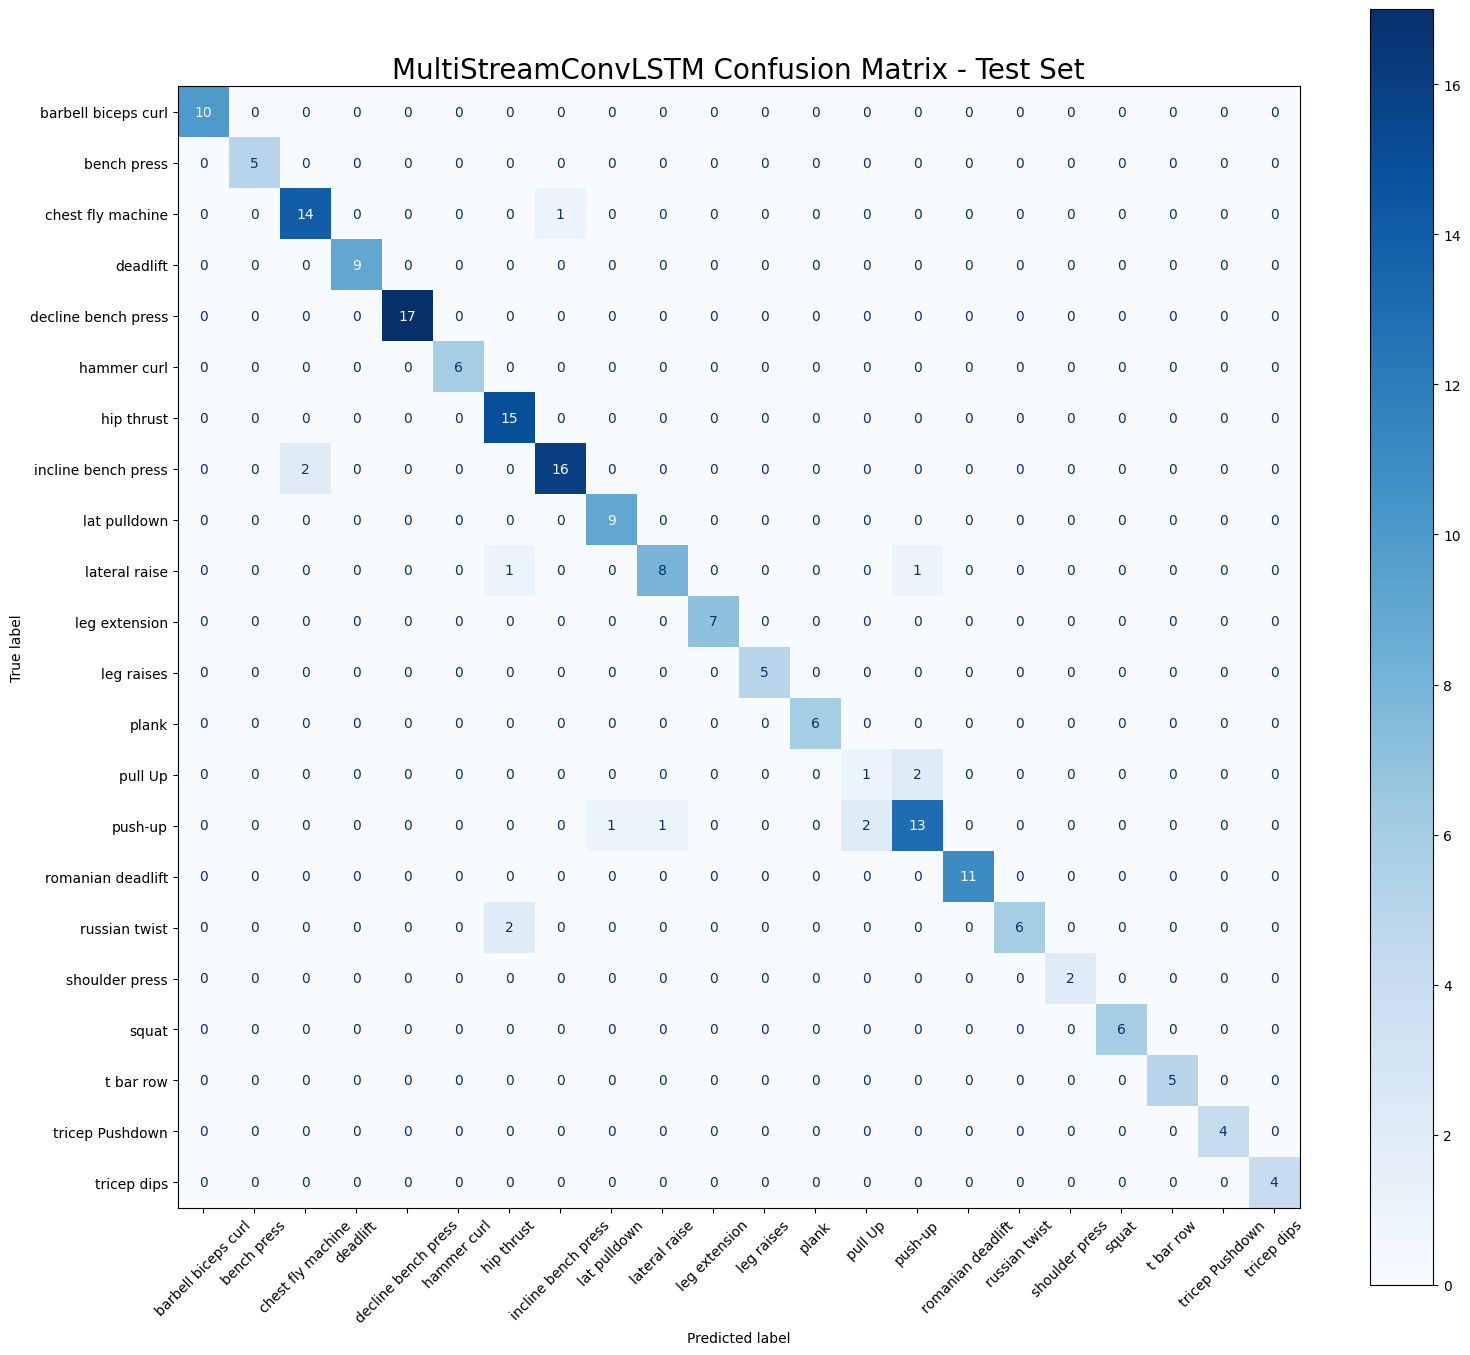

In [29]:
evaluate_model(
    model_or_class=MultiStreamConvLSTM,
    checkpoint_path=best_model_path_LSTM,
    test_loader=test_loader,
    class_names=classes_list,
    device=device,
    title="MultiStreamConvLSTM Confusion Matrix - Test Set"
)

##### Results:

The model achieved excellent performance on the test set, with an overall accuracy of **~93%**.


#### MultiStreamTransformer Model

**Overview**  
The `MultiStreamTransformer` is a neural network designed to classify exercise videos using sequences of pose, velocity, and confidence data. It uses a multi-stream approach and Transformer layers to capture both short-term and long-term patterns in the data.

**Key Components**

- **Multi-Stream Inputs:**  
  The model takes three separate inputs: pose, velocity, and confidence—just like the previous model.

- **Feature Projection:**  
  - Pose and velocity are combined and reduced to a compact feature space.
  - Confidence scores are processed separately.
  - All features are merged together for each time step.

- **Learnable Positional Encoding:**  
  The model adds a special embedding that helps it understand the order of frames in each sequence (important for understanding the flow of movement).

- **Transformer Encoder Layers:**  
  Two Transformer layers help the model learn relationships across the whole sequence, not just between neighboring frames.

- **Global Pooling and Classification:**  
  After processing the sequence, the model summarizes all frames into a single vector, then predicts the exercise class.

- **Loss Function:**  
  Focal Loss is used to address class imbalance, making training more fair for all exercise types.

**Why use this architecture?**

- **Captures complex patterns:**  
  Transformer layers help the model see both local and global patterns in exercise sequences.

- **Fuses different information:**  
  Processing each stream (pose, velocity, confidence) separately lets the model get the best out of each type of data.



In [30]:
class LearnablePositionalEncoding(nn.Module):
    def __init__(self, seq_len, d_model, dropout=0.1):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.zeros(1, seq_len, d_model))
        nn.init.trunc_normal_(self.pos_embedding, std=0.02)  # ViT-style init
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x + self.pos_embedding[:, :x.size(1), :] # x: [batch, seq, d_model]
        return self.dropout(x)


class MultiStreamTransformerClassifier(nn.Module):
    def __init__(self, seq_len, num_classes):
        super().__init__()
        self.seq_len = seq_len
        
        # Input projections
        self.spatial_proj = nn.Linear(132 * 2, 128)
        self.conf_proj = nn.Linear(33, 32)
        self.combined_proj = nn.Linear(128 + 32, 160)
        
        self.pos_encoder = LearnablePositionalEncoding(seq_len=seq_len, d_model=160)
        
        # Transformer blocks
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=160, 
            nhead=5, 
            dim_feedforward=128, 
            dropout=0.2, 
            batch_first=True  # True for [batch, seq, feature] input shape!
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

        # Classification head
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(160, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, pose, velocity, confidence):
        # pose, velocity: [batch, seq, 132], confidence: [batch, seq, 33]
        spatial = torch.cat([pose, velocity], dim=-1)           # [batch, seq, 264]
        spatial_proj = F.relu(self.spatial_proj(spatial))       # [batch, seq, 128]
        conf_proj = F.relu(self.conf_proj(confidence))          # [batch, seq, 32]
        combined = torch.cat([spatial_proj, conf_proj], dim=-1) # [batch, seq, 160]
        
        combined = combined + self.pos_encoder(combined)
        
        x = combined
        x = self.transformer(x)
        x = x.permute(0, 2, 1) # [batch, features, seq]
        x = self.global_pool(x) # [batch, features, 1]
        x = x.permute(0, 2, 1).squeeze(1) # [batch, features]
        x = self.classifier(x)
        return x

class MultiStreamTransformer(pl.LightningModule):
    def __init__(self, seq_len, num_classes, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.model = MultiStreamTransformerClassifier(seq_len, num_classes)
        self.criterion = FocalLoss(gamma=2, alpha=None)
        self.lr = lr

    def forward(self, pose, velocity, confidence):
        return self.model(pose, velocity, confidence)
    
    def training_step(self, batch, batch_idx):
        pose, velocity, confidence, y = batch
        logits = self(pose, velocity, confidence)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('train_loss', loss)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        pose, velocity, confidence, y = batch
        logits = self(pose, velocity, confidence)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss)
        self.log('val_acc', acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        pose, velocity, confidence, y = batch
        logits = self(pose, velocity, confidence)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('test_loss', loss)
        self.log('test_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer


In [31]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    save_top_k=1,         
    mode='min',           # For val_loss, lower is better
    filename='best-multistream-transformer-{epoch:02d}-{val_loss:.4f}',
    dirpath='checkpoints' 
)

sequence_length = X_train.shape[1]
num_classes = len(class_mapping)
model = MultiStreamTransformer(sequence_length, num_classes)

trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[checkpoint_callback, pl.callbacks.EarlyStopping('val_loss', patience=10)],
    log_every_n_steps=10,
    accelerator="auto",
    devices="auto"
)
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

best_model_path_transformer = checkpoint_callback.best_model_path
print("Best model saved at:", best_model_path_transformer)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MultiStreamTransformerClassifier | 404 K  | train
1 | criterion | FocalLoss                        | 0      | train
-----------------------------------------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.619     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 18.36it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │          0.90625          │
│         test_loss         │    0.16729678213596344    │
└───────────────────────────┴───────────────────────────┘

Best model saved at: /Users/tamir_gez/Documents/PythonProjects/WorkoutClassifier/checkpoints/best-multistream-transformer-epoch=37-val_loss=0.2119.ckpt


##### Model Evaluation: Test Set Results


Classification Report:
                     precision    recall  f1-score   support

barbell biceps curl       1.00      0.80      0.89        10
        bench press       0.83      1.00      0.91         5
  chest fly machine       0.74      0.93      0.82        15
           deadlift       1.00      1.00      1.00         9
decline bench press       0.94      0.88      0.91        17
        hammer curl       0.67      0.67      0.67         6
         hip thrust       0.88      1.00      0.94        15
incline bench press       1.00      0.83      0.91        18
       lat pulldown       0.89      0.89      0.89         9
      lateral raise       0.88      0.70      0.78        10
      leg extension       1.00      1.00      1.00         7
         leg raises       1.00      1.00      1.00         5
              plank       0.83      0.83      0.83         6
            pull Up       0.00      0.00      0.00         3
            push-up       0.79      0.88      0.83        17

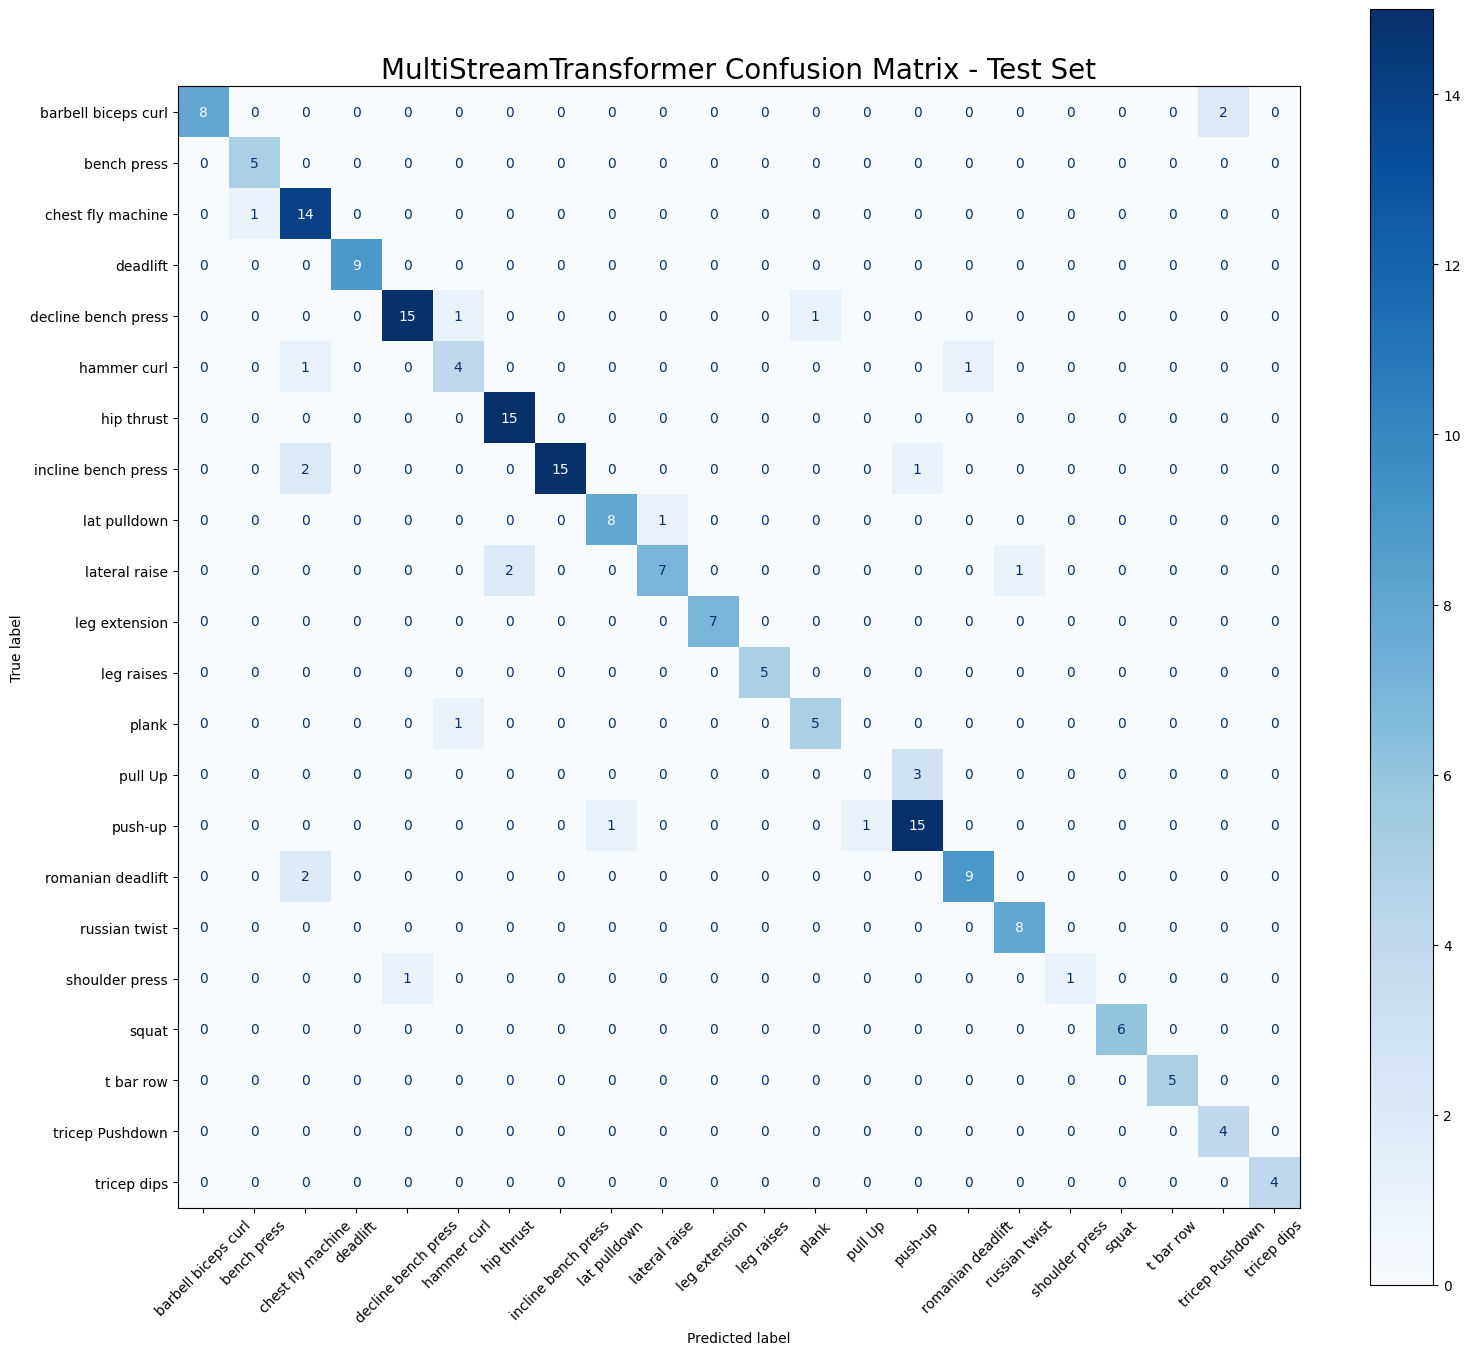

In [32]:
evaluate_model(
    model_or_class=MultiStreamTransformer,
    checkpoint_path=best_model_path_transformer,
    test_loader=test_loader,
    class_names=classes_list,
    device=device,
    title="MultiStreamTransformer Confusion Matrix - Test Set"
)

##### Results:

The `MultiStreamTransformer` model achieved strong performance on the test set, with an overall accuracy of **~93%**.

The slightly lower accuracy compared to the previous model can be due to a relatively small dataset size, as transformer typically benefit from larger datasets.


## Testing the Results Visually:

In [33]:
# ViT Model Testing
import glob
from itertools import islice

# Load the trained ViT model
ckpt_dir = "checkpoints"
vit_ckpts = sorted(
    glob.glob(os.path.join(ckpt_dir, "*vit*.ckpt")),
    key=os.path.getmtime,
    reverse=True
)
if not vit_ckpts:
    raise FileNotFoundError("No ViT checkpoint found in 'checkpoints/' directory.")
best_model_path = vit_ckpts[0]
print(f"Using ViT checkpoint: {best_model_path}")

num_classes = len(classes_list)
best_model = ViTClassifier.load_from_checkpoint(best_model_path, num_classes=num_classes)

# Set device
device = check_device()
best_model = best_model.to(device)


Using ViT checkpoint: checkpoints/best-vit-epoch=13-val_loss=0.0375.ckpt
🍎 Apple Silicon GPU (MPS) available
PyTorch Version: 2.7.0
Device set to: mps


In [34]:
def plot_images_with_labels(images, preds, labels, class_names, title="Batch: Predictions vs. True Labels", num_to_plot=8):
    """
    Plots up to num_to_plot images from a batch with predicted and true labels.
    
    Args:
        images (torch.Tensor): Batch of images, shape (N, C, H, W)
        preds (list or np.ndarray): Predicted class indices
        labels (list or np.ndarray): True class indices
        class_names (list): List of class names, indexed by class idx
        title (str): Title for the figure
        num_to_plot (int): Max number of images to show (default 8)
    """
    num_to_plot = min(num_to_plot, len(images))
    plt.figure(figsize=(18, 6))
    for i in range(num_to_plot):
        img = images[i].cpu().permute(1,2,0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # unnormalize
        img = np.clip(img, 0, 1)
        plt.subplot(2, 4, i+1)
        plt.imshow(img)
        plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}", fontsize=10)
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

Test set accuracy: 98.26%


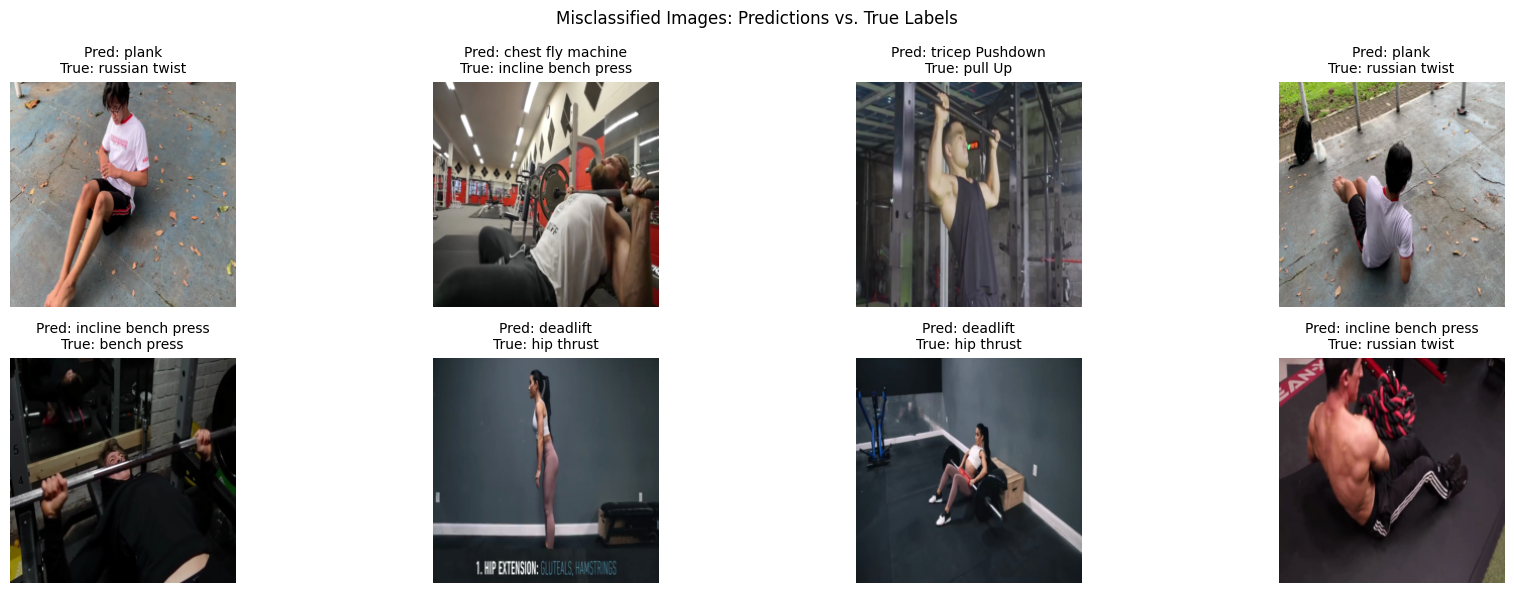

In [35]:
total_correct = 0
total_samples = 0

misclassified_images = []
misclassified_preds = []
misclassified_trues = []

best_model.eval()
with torch.no_grad():
    for images, labels in test_loader_vit:
        images, labels = images.to(device), labels.to(device)
        logits = best_model(images)
        preds = torch.argmax(logits, dim=1)

        # Accuracy counter
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

        # Misclassified sample collection
        mask = preds != labels
        if mask.any():
            misclassified_images.append(images[mask])
            misclassified_preds.extend(preds[mask].cpu().tolist())
            misclassified_trues.extend(labels[mask].cpu().tolist())

accuracy = total_correct / total_samples
print(f"Test set accuracy: {accuracy * 100:.2f}%")

# Flatten misclassified images list
if misclassified_images:
    misclassified_images = torch.cat(misclassified_images)
else:
    misclassified_images = torch.tensor([])

num_to_plot = min(8, len(misclassified_images))
plot_images_with_labels(
    misclassified_images, 
    misclassified_preds, 
    misclassified_trues, 
    classes_list, 
    title="Misclassified Images: Predictions vs. True Labels",
    num_to_plot=num_to_plot
)

if num_to_plot == 0:
    print("No misclassified images found in the test set! 🎉")


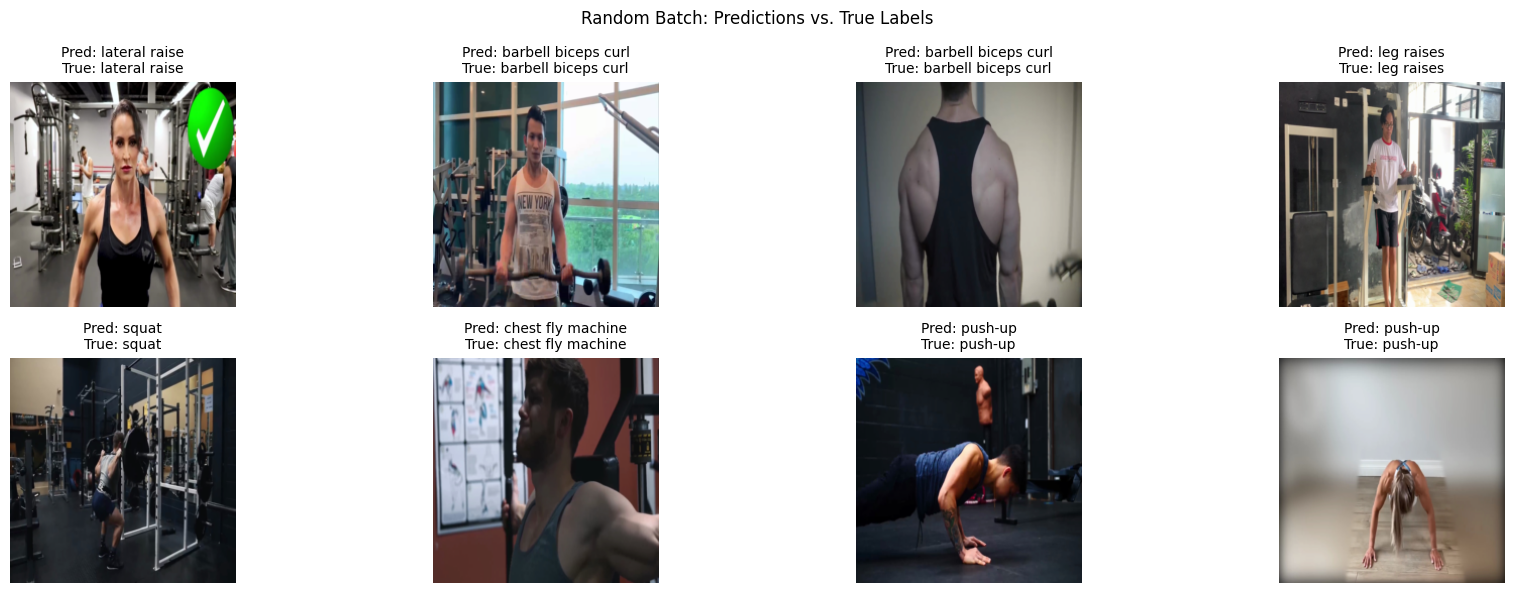

In [36]:
# Just a random batch from test set to visualize the results
num_batches = len(test_loader_vit)
rand_idx = random.randint(0, num_batches - 1)
batch = next(islice(test_loader_vit, rand_idx, rand_idx+1))
images, labels = batch
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    logits = best_model(images)
    preds = torch.argmax(logits, dim=1)

plot_images_with_labels(images, preds.cpu().numpy(), labels.cpu().numpy(), classes_list, title="Random Batch: Predictions vs. True Labels")


### Testing Preprocessing and Prediction Time for Each Model:

In [37]:
def get_random_video_path(dataset_dir="dataset", video_exts=None):
    """
    Get a random video path from the dataset
    """
    if video_exts is None:
        video_exts = ('.mp4', '.avi', '.mov', '.mkv', '.wmv', '.flv', '.MOV', '.MP4')
    
    class_folders = [f for f in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, f))]
    if not class_folders:
        raise FileNotFoundError(f"No class folders found in {dataset_dir}")
    chosen_folder = random.choice(class_folders)

    folder_path = os.path.join(dataset_dir, chosen_folder)
    video_files = [f for f in os.listdir(folder_path) if f.lower().endswith(video_exts)]
    if not video_files:
        raise FileNotFoundError(f"No video files found in folder: {chosen_folder}")
    chosen_video = random.choice(video_files)
    video_path = os.path.join(folder_path, chosen_video)
    return video_path, chosen_folder, chosen_video

video_path, chosen_folder, chosen_video = get_random_video_path("dataset")
print(f"Selected video: {chosen_video}")

Selected video: squat_22.mp4


In [38]:
max_frames = 45
num_frames_img = 10

class_mapping = np.load('processed_data_landmark/class_mapping.npy', allow_pickle=True).item()
class_names = [None] * len(class_mapping)
for name, idx in class_mapping.items():
    class_names[idx] = name

In [42]:
import time

prep = WorkoutDataPreparator(base_folder=None, max_frames=max_frames)

start_time = time.time()
features, _ = prep.extract_poses_from_video(video_path, no_type=True)
preprocess_time = time.time() - start_time

poses = torch.from_numpy(features[:, :132]).unsqueeze(0).float().to(device)
velocity = torch.from_numpy(features[:, 132:264]).unsqueeze(0).float().to(device)
confidence = torch.from_numpy(features[:, 264:]).unsqueeze(0).float().to(device)

best_model_lstm = MultiStreamConvLSTM.load_from_checkpoint(
    'checkpoints/best-multistream-lstm-epoch=61-val_loss=0.1405.ckpt',
    sequence_length=max_frames, num_classes=len(class_names)
).to(device).eval()

best_model_transformer = MultiStreamTransformer.load_from_checkpoint(
    'checkpoints/best-multistream-transformer-epoch=22-val_loss=0.2691.ckpt',
    seq_len=max_frames, num_classes=len(class_names)
).to(device).eval()

with torch.no_grad():
    t0 = time.time()
    logits_lstm = best_model_lstm(poses, velocity, confidence)
    lstm_time = time.time() - t0
    pred_class_lstm = class_names[torch.argmax(torch.softmax(logits_lstm, 1), 1).item()]
    t1 = time.time()
    logits_trans = best_model_transformer(poses, velocity, confidence)
    trans_time = time.time() - t1
    pred_class_trans = class_names[torch.argmax(torch.softmax(logits_trans, 1), 1).item()]


I0000 00:00:1748521249.959372 10998405 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M1 Pro
W0000 00:00:1748521250.140496 11251667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1748521250.234106 11251667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1748521250.324488 11251673 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


In [44]:
import time
from PIL import Image


def extract_frames(video_path, num_frames):
    """
    Extract a fixed number of frames from a video at regular intervals.
    
    Args:
        video_path (str): Path to the video file.
        num_frames (int): Number of frames to extract.
    
    Returns:
        list: List of extracted frames as PIL images.
    """
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    idxs = np.linspace(0, total_frames-1, num_frames, dtype=int)
    frames = []
    for idx in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret: continue
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(Image.fromarray(frame))
    cap.release()
    if len(frames) < num_frames and frames:
        frames += [frames[-1]] * (num_frames - len(frames))
    return frames

def predict_img_model(video_path, model, class_names, transform, num_frames, device):
    """
    Predict the class of a video using a pre-trained image classification model.
    
    Args:
        video_path (str): Path to the video file.
        model (torch.nn.Module): Pre-trained image classification model.
        class_names (list): List of class names.
        transform (torchvision.transforms.Compose): Image transformation pipeline.
        num_frames (int): Number of frames to extract from the video.
        device (torch.device): Device to run the model on (e.g., 'cuda' or 'cpu').
    
    Returns:
        tuple: A tuple containing the predicted class, preprocessing time, and inference time.
    """
    t0 = time.time()
    frames = extract_frames(video_path, num_frames)
    frames_tensor = torch.stack([transform(f) for f in frames]).to(device)
    preprocess_time = time.time() - t0
    with torch.no_grad():
        t1 = time.time()
        outputs = model(frames_tensor)
        inference_time = time.time() - t1
        probs = torch.softmax(outputs.cpu(), 1).mean(0)
        pred_class = class_names[probs.argmax().item()]
    return pred_class, preprocess_time, inference_time

best_model_cnn = SimpleCNN.load_from_checkpoint(
    'checkpoints/best-simplecnn-epoch=22-val_acc=0.9703.ckpt', num_classes=len(class_names)
).to(device).eval()
best_model_vit = ViTClassifier.load_from_checkpoint(
    'checkpoints/best-vit-epoch=19-val_loss=0.0328.ckpt', num_classes=len(class_names)
).to(device).eval()

cnn_pred, cnn_prep_time, cnn_inf_time = predict_img_model(
    video_path, best_model_cnn, classes_list, transform_cnn, num_frames_img, device
)
vit_pred, vit_prep_time, vit_inf_time = predict_img_model(
    video_path, best_model_vit, classes_list, transform_vit, num_frames_img, device
)


In [45]:
results = pd.DataFrame([
    {
        "Model": "LSTM",
        "Prediction": pred_class_lstm,
        "Preprocessing (sec)": preprocess_time,
        "Inference (sec)": lstm_time,
        "Total (sec)": preprocess_time + lstm_time
    },
    {
        "Model": "Transformer",
        "Prediction": pred_class_trans,
        "Preprocessing (sec)": preprocess_time,
        "Inference (sec)": trans_time,
        "Total (sec)": preprocess_time + trans_time
    },
    {
        "Model": "SimpleCNN",
        "Prediction": cnn_pred,
        "Preprocessing (sec)": cnn_prep_time,
        "Inference (sec)": cnn_inf_time,
        "Total (sec)": cnn_prep_time + cnn_inf_time
    },
    {
        "Model": "ViT",
        "Prediction": vit_pred,
        "Preprocessing (sec)": vit_prep_time,
        "Inference (sec)": vit_inf_time,
        "Total (sec)": vit_prep_time + vit_inf_time
    }
])

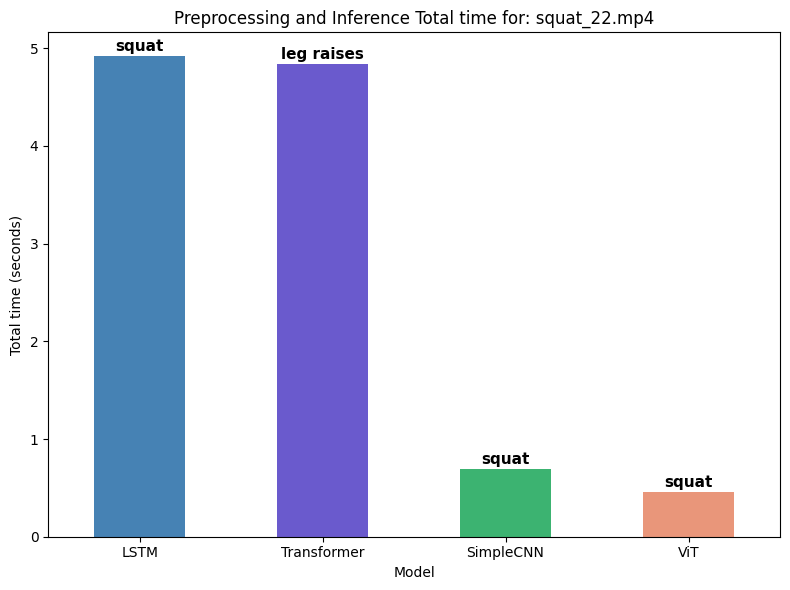

In [46]:
ax = results.plot(
    x="Model", y="Total (sec)", kind="bar", legend=False, figsize=(8, 6),
    color=["#4682B4", "#6A5ACD", "#3CB371", "#E9967A"]
)
plt.title(f"Preprocessing and Inference Total time for: {os.path.basename(video_path)}")
plt.ylabel("Total time (seconds)")
plt.xticks(rotation=0)

# Annotate predictions above each bar
for i, row in results.iterrows():
    ax.text(
        i, row["Total (sec)"] + 0.02, f"{row['Prediction']}",
        ha="center", va="bottom", fontsize=11, fontweight="bold", color="black"
    )

plt.tight_layout()
plt.show()

## Conclusion

This project explored two routes to classifying workout videos:

**1. Image-Based Classification**  
We trained two frame-based models:  
- **SimpleCNN** – a lightweight custom CNN.  
- **ViTClassifier** – a ViT-B/16 model fine-tuned with transfer learning, achieving **the highest test accuracy score**.

**2. Pose Estimation-Based Classification**  
Using MediaPipe landmarks, we built:  
- **MultiStreamConvLSTM** – Conv1D + LSTM layers on pose sequences.  
- **MultiStreamTransformer** – a Transformer architecture on pose sequences as well.

All models were evaluated with accuracy and confusion matrices to assess both overall and per-class performance.

The results show that The ViT model outperformed other models, both in accuracy and in overall prediction speed (including preprocessing). Pose-based approaches, while valuable for understanding movement, were generally slower and less accurate in this setting.

> The ViT model is saved in the `checkpoints` directory after running the notebook.
> I've also added my saved model in the root folder `vit_classifier_weights.pth`.

## Resources

[1] https://learnopencv.com/introduction-to-video-classification-and-human-activity-recognition/

[2] https://medium.com/@iitkarthik/master-video-classification-with-transformers-train-a-hybrid-transformer-classifier-ce654e52cfc8

[3] https://github.com/chrisprasanna/Exercise_Recognition_AI/blob/main/ExerciseDecoder.ipynb

[4] https://medium.com/@sanjay_dutta/flower-image-classification-using-vision-transformer-vit-50b71694cda3

[5] https://www.kaggle.com/code/ezerelbaz/workout-video-classifier-usinng-cnn-lstm-model